# The Arctic Surface Heating Efficiency of Tropospheric Energy Flux Events

#### This notebook includes the python code used for the figures in Cardinale and Rose (2022) https://doi.org/10.1175/JCLI-D-21-0852.1.

In [1]:
import xarray as xr
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integ
import pandas as pd
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import cartopy
import cartopy.crs as ccrs
import scipy.stats as sp
import palettable as palet
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import user-defined functions from efficiency.py in the functions folder
import functions.efficiency as comp
from functions.efficiency import C,A,ufunc,detrend,sid,Cp

# Data

See ***merra2_data_download.ipynb*** for instructions on MERRA-2 data download, including energy flux calculations.

In [3]:
data_loc = '../condensed_data/'
#see section 1 from merra2_data_download.ipynb
merra_ET = xr.open_dataset(data_loc + 'MERRA2_ET_NH_1980_2021.nc')
merra_EDDY = xr.open_dataset(data_loc + 'MERRA2_EDDY_NH_1980_2021.nc')
#see section 2
merra_Hm = xr.open_dataset(data_loc + 'MERRA2_Hm_NH_1980_2021.nc')
#see section 3
THF = xr.open_dataset(data_loc + 'MERRA2_SHLHFLX_NH_1980_2021.nc')
THF_spatial = xr.open_dataset(data_loc + 'MERRA2_FLX_spatial_NH_1980_2021')
RAD = xr.open_dataset(data_loc + 'MERRA2_RAD_NH_1980_2021.nc')
LW_spatial = xr.open_dataset(data_loc + 'MERRA2_LW_spatial_NH_1980_2021.nc')
#see section 4
merra_STAB = xr.open_dataset(data_loc + 'MERRA2_T2M_STAB_NH_1980_2021.nc')
#see section 5
merra_SIC = xr.open_dataset(data_loc + 'MERRA2_SIC_NH_1980_2021.nc')
#see section 6
CLDL = xr.open_dataset(data_loc+'MERRA2_CLDL_NH_1980_2021.nc')
CLDM = xr.open_dataset(data_loc+'MERRA2_CLDM_NH_1980_2021.nc')
CLDH = xr.open_dataset(data_loc+'MERRA2_CLDH_NH_1980_2021.nc')
SLR_CLR = xr.open_dataset(data_loc+'MERRA2_SLR_CLR_NH_1980_2021')
OLR_CLR = xr.open_dataset(data_loc+'MERRA2_OLR_CLR_NH_1980_2021')

In [4]:
#ocean and land masks 
FROCEAN = xr.open_dataset(data_loc + 'FROCEAN.nc')
mask = FROCEAN.isel(time=0).sel(lat=slice(60,90)).drop('time') > 0 
mask2 = FROCEAN.isel(time=0).sel(lat=slice(70,90)).drop('time') > 0 
mask3 = FROCEAN.isel(time=0).sel(lat=slice(70,90)).drop('time') == 0 
mask_EDDY=(merra_EDDY.EDDY_SH.mean('time').where(merra_EDDY.EDDY_SH.mean('time')!=0))*0+1

In [5]:
#winter: NDJFM
#winter_ext: ONJFMA (used for composite analysis)
winter = merra_ET.time.where(xr.ufuncs.logical_or(merra_ET.time.dt.month>10
                                         ,merra_ET.time.dt.month<4)).dropna('time')
winter_ext = merra_ET.time.where(xr.ufuncs.logical_or(merra_ET.time.dt.month>9
                                         ,merra_ET.time.dt.month<5)).dropna('time')

# 1. Daily anomalies

All data has been daily averaged and either zonally (70$^{\circ}$N) or polar cap–averaged (70$^{\circ}$N–90$^{\circ}$N), unless otherwise stated. Some anomalies are linearly detrended during the "extended winter" (October through April). The detrending includes October and April as some October and April days are included in the composite analysis. However, all winter tropospheric energy flux events are limited to Novemeber through March.

## Energy Fluxes

**Acronyms & Abbreviations**:
* MSE – moist static energy flux (combined sensible, latent, and geopotential fluxes; 70$^{\circ}$N)
* SH – sensible heat flux ($c_{p}vT$)
* LH – latent heat flux ($L_{v}vq$)
* GP – geopotential energy flux ($gvz$)
* EDDY – eddy flux (departures from the zonal mean; not zonally averaged)
* anom – anomaly (relative to the daily mean annual cycle)
* dtrend – detrended (linear)

In [6]:
#both the anomaly and linearly detrended anomalies are computed (linear detrended anomalies are used to calcuated the surface heating efficiency)
MSE = merra_ET.LH+merra_ET.SH+merra_ET.GP
LH_anom, SH_anom, GP_anom, MSE_anom = [comp.anom_daily(array) 
                                       for array in [merra_ET.LH,merra_ET.SH,merra_ET.GP,MSE]]
LH_anom_dtrend, SH_anom_dtrend, GP_anom_dtrend, MSE_anom_dtrend = [ufunc(array.sel(time=winter_ext),detrend)
                                                                  for array in [LH_anom,SH_anom,GP_anom,MSE_anom]] 


EDDY_MSE = merra_EDDY.EDDY_LH+merra_EDDY.EDDY_SH+merra_EDDY.EDDY_GP
[EDDY_LH_anom, EDDY_SH_anom, 
 EDDY_GP_anom, EDDY_MSE_anom] = [comp.anom_daily(array)
                                 for array in [merra_EDDY.EDDY_LH,merra_EDDY.EDDY_SH
                                               ,merra_EDDY.EDDY_GP,EDDY_MSE]]
[EDDY_LH_anom_dtrend, EDDY_SH_anom_dtrend, 
 EDDY_GP_anom_dtrend, EDDY_MSE_anom_dtrend] = [ufunc(array.sel(time=winter_ext),detrend) 
                                               for array in [EDDY_LH_anom, EDDY_SH_anom,
                                                             EDDY_GP_anom, EDDY_MSE_anom]]

## Moist enthalpy tendency and sensible energy

* DMENTDT – moist enthalpy (latent and sensible energy) tendency ($\frac{dh_{m}}{dt}$)
    * DMENTDT does not explicitely include contributions from the geopotental tendency term&mdash;as a consequence of hydrostatic balance, the sensible component (i.e., $c_{p} T$) includes contributions from internal ($c_{v} T$) and potential energy.
* SENSIBLE – Sensible energy ($c_{p} T$)

In [7]:
DMENTDT_anom, SENSIBLE_anom = [comp.anom_daily(array)
                               for array in [merra_Hm.DMENTDT,merra_Hm.SENSIBLE]]
DMENTDT_anom_dtrend, SENSIBLE_anom_dtrend = [ufunc(array.sel(time=winter_ext),detrend) for array in [DMENTDT_anom,SENSIBLE_anom]]

## Surface and TOA fluxes

* SHLH – sensible & latent THFs (turbulent heat fluxes)
* DLR – downward longwave radiation ; SALR – surface absorbed longwave radiation
* ULR – upward longwave radiaiton ; SELR – surface emitted longwave radiation
* OLR – outgoing longwave radiation
* CLR – clear-sky
* PC – polar cap-averaged
* spatial – no spatial averaging 

In [8]:
SHLH = -(THF.SHFLX_PC+THF.LHFLX_PC)
[OLR_anom, DLR_anom, DLR_spatial_anom, ULR_anom, ULR_spatial_anom, SHLH_anom, 
 SHLH_spatial_anom, OLR_CLR_anom, DLR_CLR_anom]  = [comp.anom_daily(array)
                                                    for array in [RAD.OLR_PC,RAD.SALR_PC,LW_spatial.SALR_PC,-RAD.SELR_PC,-LW_spatial.SELR_PC,SHLH,-THF_spatial.SHLH
                                                                  ,OLR_CLR.OLR_PC_CLR,SLR_CLR.SALR_PC_CLR]]
[OLR_anom_dtrend, DLR_anom_dtrend, ULR_anom_dtrend, SHLH_anom_dtrend
 ,OLR_CLR_anom_dtrend, DLR_CLR_anom_dtrend]  = [ufunc(array.sel(time=winter_ext),detrend) 
                                                                         for array in [OLR_anom,DLR_anom,ULR_anom,SHLH_anom
                                                                                       ,OLR_CLR_anom,DLR_CLR_anom]]

[SHLH_spatial_anom_dtrend, DLR_spatial_anom_dtrend, ULR_spatial_anom_dtrend]  = [ufunc(array.sel(time=winter_ext),detrend) 
                                                                                 for array in [SHLH_spatial_anom, DLR_spatial_anom, ULR_spatial_anom]]

## Temperature, stability, and sea ice

* STAB – lower-tropospheric stability
* T2M – 2-meter temperature
* SIC – sea ice concetration 

In [9]:
STAB_anom, T2M_anom, SIC_anom = [comp.anom_daily(array)
                                 for array in [merra_STAB.STAB,merra_STAB.T2M,merra_SIC.SIC_6090*100]]


## Clouds

* CLDL – low clouds (below 700 hPa)
* CLDM – mid clouds (700–400 hPa)
* CLDH – hgh clouds (above 400 hPa)

In [10]:
CLDL_anom, CLDM_anom, CLDH_anom = [comp.anom_daily(array)
                                   for array in [CLDL.CLDL,CLDM.CLDM,CLDH.CLDH]]

# 2. Surface heating efficiency ($E_{\mathrm{trop}}$)

## Definition and winter mean

* NTES – not tropospheric energy source 
    * calculated from detrended anomalies and filtered (low-pass; 2-day cutoff frequency)
* NSF – net surface flux
* F_trop – polar cap–averaged MSE flux convergence
* E_trop – surface heating efficiency

In [11]:
NTES = ufunc(comp.integrate_trop((MSE_anom_dtrend*C/A)-DMENTDT_anom_dtrend/sid),comp.low_filt)

In [12]:
F_trop_anom_dtrend = ((ufunc(comp.integrate_trop(MSE_anom_dtrend*C/A),comp.low_filt)))

In [13]:
NSF_anom_dtrend = DLR_anom_dtrend+ULR_anom_dtrend+SHLH_anom_dtrend

In [14]:
E_trop = (NSF_anom_dtrend/NTES).sel(time=winter)

In [15]:
print('Winter (NDJFM) mean $E_{\mathrm{trop}}$:' ' ' + str(E_trop.where(xr.ufuncs.logical_and(E_trop>=0,E_trop<=1)).mean().round(2).values))

Winter (NDJFM) mean $E_{\mathrm{trop}}$: 0.5


## Average $E_{\mathrm{trop}}$ of tropospheric energy flux events 

In [16]:
extra_nan=DLR_anom.where(xr.ufuncs.logical_and(DLR_anom.time.dt.month==10,DLR_anom.time.dt.time==31)).dropna('time')*np.nan

In [17]:
E_trop2 = xr.concat([E_trop.sel(time=slice('1980-01-31','2020-03-31'))
                       ,extra_nan],'time').sortby('time').reset_coords('dayofyear',drop=True)

In [18]:
NTES_w = xr.concat([NTES.sel(time=winter).sel(time=slice('1980-01-31','2020-03-31'))
                                                   ,extra_nan],'time').sortby('time').reset_coords('dayofyear',drop=True)
NSF_anom_dtrend_w = xr.concat([NSF_anom_dtrend.sel(time=winter).sel(time=slice('1980-01-31','2020-03-31'))
                                                 ,extra_nan],'time').sortby('time').reset_coords('dayofyear',drop=True)

In [19]:
E_trop_avg,event_size=comp.event_average(E_trop2,comp.event_days(array=NTES_w,sigma=0))

In [20]:
help(comp.event_average)

Help on function event_average in module functions.efficiency:

event_average(array, events)
    Returns a cumulative average and size of each event. The 'event array' should include all consecutive days in each event. The cumulative average of the event will be returned on the start day of the event.



In [21]:
NTES_integ, NTES_integ_full = comp.event_integ(NTES_w,comp.event_days(array=NTES_w,sigma=0))
NSF_anom_integ, NSF_anom_integ_full = comp.event_integ(NSF_anom_dtrend_w,comp.event_days(array=NTES_w,sigma=0))

In [22]:
event_size_integ = NTES_integ_full.where(xr.ufuncs.logical_and(NTES_integ_full.fillna(0) > NTES_integ_full.shift(time=1).fillna(0),
                                              NTES_integ_full.fillna(0) > NTES_integ_full.shift(time=-1).fillna(0))).dropna('time')

In [23]:
#find the cumulative averaged efficnecy at the event date (i.e., the date when the threshold is reached)
E_trop_event=E_trop_avg.sel(time=NTES_integ.time)

In [24]:
print('high-efficiency threshold:' ' ' + str(E_trop_event.quantile(.75).values.round(2)))
print('low-efficiency threshold:' ' ' + str(E_trop_event.quantile(.25).values.round(2)))

high-efficiency threshold: 0.63
low-efficiency threshold: 0.42


In [25]:
high_eff_time=E_trop_event.where(E_trop_event>=E_trop_event.quantile(.75)).dropna('time').time
low_eff_time=E_trop_event.where(E_trop_event<=E_trop_event.quantile(.25)).dropna('time').time
med_eff_time=E_trop_event.where(xr.ufuncs.logical_and(E_trop_event>E_trop_event.quantile(.25)
                                             ,E_trop_event<E_trop_event.quantile(.75))).dropna('time').time

# 3. Results

## Figure 1

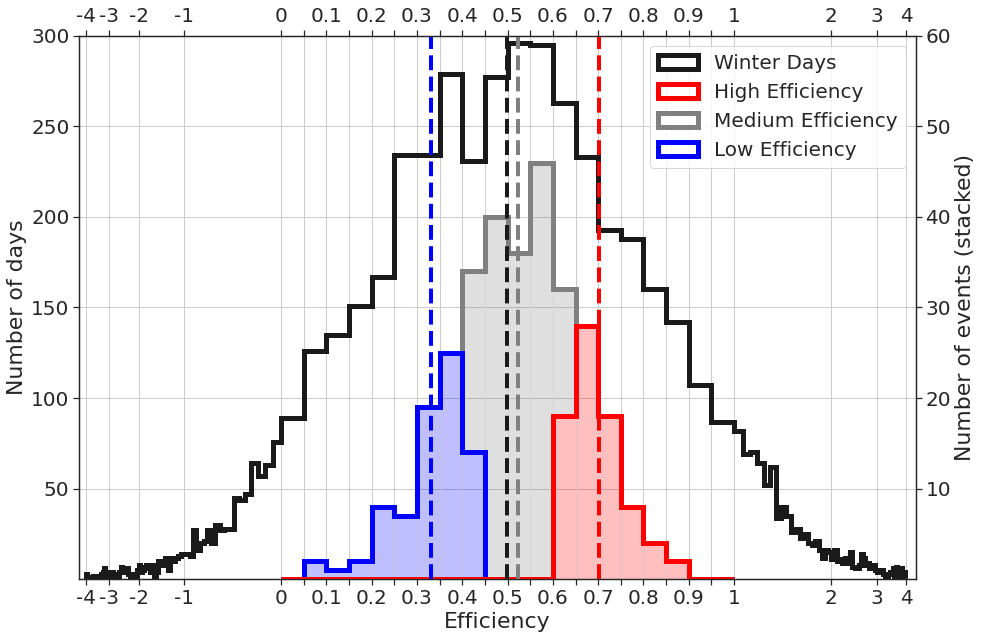

In [26]:
import matplotlib.ticker as ticker
fig = plt.figure( figsize=(15,10) )
ax = plt.subplot(111)
ax.hist(E_trop.where(xr.ufuncs.logical_and(E_trop>-4,E_trop<4))-.5,bins=list(np.arange(-4.5,3.55,.05)),histtype='step', alpha=1,color='k',lw=5,label='Winter Days')
ax2 = ax.twinx()
c,d,e=ax2.hist([E_trop_event.sel(time=high_eff_time)-.5,E_trop_event.sel(time=low_eff_time)-.5,
        E_trop_event.sel(time=med_eff_time)-.5],range=(-.5,.5),bins=20,stacked=True
        ,histtype='barstacked',color=['red','blue','gray'],alpha=.25)
ax2.hist([E_trop_event.sel(time=high_eff_time)-.5,E_trop_event.sel(time=low_eff_time)-.5,
        E_trop_event.sel(time=med_eff_time)-.5],range=(-.5,.5),bins=20,stacked=True
        ,histtype='step',color=['red','blue','gray'],label=['High Efficiency','Low Efficiency','Medium Efficiency'],alpha=1,lw=5)
ax2.axvline(E_trop_event.sel(time=low_eff_time).mean()-.5,color='blue',lw=4,ls='--')
ax2.axvline(E_trop_event.sel(time=high_eff_time).mean()-.5,color='red',lw=4,ls='--')
ax2.axvline(E_trop_event.sel(time=med_eff_time).mean()-.5,color='gray',lw=4,ls='--')
ax2.axvline(E_trop.where(xr.ufuncs.logical_and(E_trop>=0,E_trop<=1)).mean()-.5,color='k',lw=4,ls='--')
handles, labels = ax2.get_legend_handles_labels()
handles2, labels2 = ax.get_legend_handles_labels()

ax2.legend([handles2[0],handles[2],handles[0],handles[1]], [labels2[0],labels[2],labels[0],labels[1]],fontsize=20)

ax.set_xscale("symlog",linscalex=1,linthreshx=.5,subsx=[-.45,-.35, -.25])
ax.xaxis.set_ticks_position('both')
ax.tick_params(labeltop=True)
ax.set_yticks([50,100,150,200,250,300])
ax2.set_yticks([10,20,30,40,50,60])
ax.set_ybound(0,300)
ax2.set_ybound(0,60)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.set_xlabel('Efficiency',fontsize=22)
ax.set_ylabel('Number of days',fontsize=22)
ax2.set_ylabel('Number of events (stacked)',fontsize=22)
ax.set_xticks([-4.5,-3.5,-2.5,-1.5,-.5,-.45,-.4,-.35,-.3,-.25,-.2,-.15,-.1,-.05,0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,1.5,2.5,3.5])
ax.set_xticklabels([-4,-3,-2,-1,0,'',.1,'',.2,'',.3,'',.4,'',.5,'',.6,'',.7,'',.8,'',.9,'',1,2,3,4])
plt.minorticks_off() 
ax.grid()
ax.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
#plt.savefig('hist_Final.pdf', bbox_inches='tight')


## Figure 2

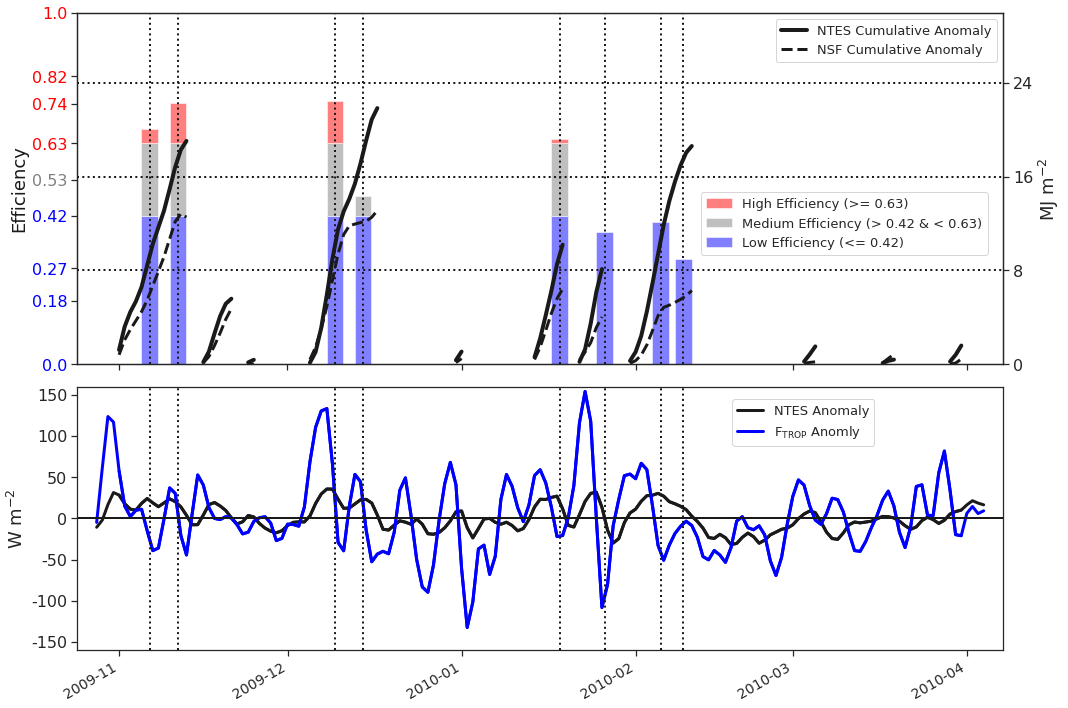

In [27]:
fig = plt.figure( figsize=(15,10) )
gs = plt.GridSpec(2, 1,
                       width_ratios=[1],
                       height_ratios=[1,.75]
                       )
ax = fig.add_subplot(gs[0])
year1 = '2009'
year2 = '2010'

eff_array = E_trop_event.sel(time=slice('{}-11'.format(year1),'{}-04-01'.format(year2)))
eff_array2 = E_trop_event.sel(time=slice('{}-11'.format(year1),'{}-04-01'.format(year2)))
[ax.axvspan(xmin=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day-1,0)
           ,xmax=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day+1,23),
            ymax=E_trop_event.quantile(.25),facecolor='blue',alpha=.5) for x in eff_array.time.where(eff_array>E_trop_event.quantile(.25)).dropna('time')]

[ax.axvspan(xmin=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day-1,0)
           ,xmax=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day+1,23),
            ymin=E_trop_event.quantile(.25),ymax=E_trop_event.quantile(.75),facecolor='gray',alpha=.5) for x in eff_array.time.where(eff_array>=E_trop_event.quantile(.75)).dropna('time')]

line = [ax.axvspan(xmin=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day-1,0)
           ,xmax=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day+1,23),
            ymin=E_trop_event.quantile(.75),ymax=eff_array.sel(time=x),facecolor='red',alpha=.5) for x in eff_array.time.where(eff_array>=E_trop_event.quantile(.75)).dropna('time')]

line2 = [ax.axvspan(xmin=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day-1,0)
           ,xmax=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day+1,23),
            ymin=E_trop_event.quantile(.25),ymax=eff_array.sel(time=x),facecolor='gray',alpha=.5) for x in eff_array.time.where(
    xr.ufuncs.logical_and(eff_array>E_trop_event.quantile(.25),eff_array<E_trop_event.quantile(.75))).dropna('time')]

line3 = [ax.axvspan(xmin=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day-1,0)
           ,xmax=datetime(eff_array.sel(time=x).time.dt.year,eff_array.sel(time=x).time.dt.month,eff_array.sel(time=x).time.dt.day+1,23),
            ymin=0,ymax=eff_array.sel(time=x),facecolor='blue',alpha=.5) for x in eff_array.time.where(eff_array<=E_trop_event.quantile(.25)).dropna('time')]

line[0].set_label('High Efficiency (>= 0.63)')
line2[0].set_label('Medium Efficiency (> 0.42 & < 0.63)')
line3[0].set_label('Low Efficiency (<= 0.42)')

[ax.axvline(datetime(eff_array2.sel(time=x).time.dt.year,eff_array2.sel(time=x).time.dt.month
                    ,eff_array2.sel(time=x).time.dt.day,11),color='k',lw=2,ls=':') for x in eff_array2.time]

ax2 = ax.twinx()

NTES_integ_full.sel(time=slice('{}-11'.format(year1),'{}-04-01'.format(year2))).plot(ls='-',ax=ax2,c='k',lw=4,marker='',label='NTES Cumulative Anomaly')
NSF_anom_integ_full.sel(time=slice('{}-11'.format(year1),'{}-04-01'.format(year2))).plot(ls='--',ax=ax2,c='k',lw=3,label='NSF Cumulative Anomaly')

ax3 = fig.add_subplot(gs[1])
NTES.sel(time=winter).sel(time=slice('2009-11','2010-04-01')).plot(ls='-',ax=ax3,c='k',lw=3,label='NTES Anomaly')
NTES.sel(time=slice('{}-10-28'.format(year1),'{}-04-04'.format(year2))).plot(ls='-',ax=ax3,c='k',lw=3,label='')
F_trop_anom_dtrend.sel(time=winter).sel(time=slice('{}-11'.format(year1),'{}-04-01'.format(year2))).plot(ls='-',ax=ax3,c='blue',lw=3,label='$\mathregular{F_{TROP}}$ Anomly')
F_trop_anom_dtrend.sel(time=slice('{}-10-28'.format(year1),'{}-04-04'.format(year2))).plot(ls='-',ax=ax3,c='blue',lw=3,label='')

ax3.axhline(0,color='k',ls='-',lw=2)
ax2.set_yticks(np.arange(0,108,8))
ax.set_yticks([0,E_trop_event.quantile(.01),E_trop_event.quantile(.05),E_trop_event.quantile(.25),E_trop_event.quantile(.5),E_trop_event.quantile(.75),
              E_trop_event.quantile(.95),E_trop_event.quantile(.99),1])
ax.set_yticklabels(np.array([0,E_trop_event.quantile(.01).round(2),E_trop_event.quantile(.05).round(2),E_trop_event.quantile(.25).round(2),E_trop_event.quantile(.5).round(2),E_trop_event.quantile(.75).round(2),
              E_trop_event.quantile(.95).round(2),E_trop_event.quantile(.99).round(2),1]),fontsize=16)
ax2.set_yticklabels([0,8,16,24],fontsize=16)
ax3.set_yticklabels(np.arange(-200,200,50),fontsize=16)
colors = ['blue','blue','blue','blue', 'gray', 'red','red','red','red']
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)
ax2.set_ybound(0,30)
ax.set_ybound(0.,1)
ax.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax2.set_ylabel('MJ m$^{-2}$',fontsize=18)
ax3.set_ylabel('W m$^{-2}$',fontsize=18)
ax.set_ylabel('Efficiency',color='k',fontsize=18)
ax2.legend(fontsize=13)
ax.legend(loc='center right',fontsize=13, bbox_to_anchor=(.99, .4))
ax3.set_xticklabels(['2009-11','2009-12','2010-01','2010-02','2010-03','2010-04'],fontsize=14)
ax.set_xticklabels('')
ax3.set_ybound(-160,160)
ax2.axhline(8,ls=':',color='k',lw=2)
ax2.axhline(16,ls=':',color='k',lw=2)
ax2.axhline(24,ls=':',color='k',lw=2)
[ax3.axvline(datetime(eff_array2.sel(time=x).time.dt.year,eff_array2.sel(time=x).time.dt.month
                    ,eff_array2.sel(time=x).time.dt.day,11),color='k',lw=2,ls=':') for x in eff_array2.time]
ax3.legend(fontsize=13,loc='best', bbox_to_anchor=(.70, .75))
ax3.margins(x=.02225)
fig.tight_layout()
#plt.savefig('events_T8_final.pdf', bbox_inches='tight')

## Composite Analysis

### Event mean composites (30 days before and after the central date)

In [28]:
MSE_anom_comp_high_eff, MSE_anom_comp_med_eff, MSE_anom_comp_low_eff = [comp.composite(MSE_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
LH_anom_comp_high_eff, LH_anom_comp_med_eff, LH_anom_comp_low_eff = [comp.composite(LH_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
SH_anom_comp_high_eff, SH_anom_comp_med_eff, SH_anom_comp_low_eff = [comp.composite(SH_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
GP_anom_comp_high_eff, GP_anom_comp_med_eff, GP_anom_comp_low_eff = [comp.composite(GP_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

In [29]:
EDDY_MSE_anom_comp_high_eff, EDDY_MSE_anom_comp_med_eff, EDDY_MSE_anom_comp_low_eff = [comp.composite(EDDY_MSE_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
EDDY_LH_anom_comp_high_eff, EDDY_LH_anom_comp_med_eff, EDDY_LH_anom_comp_low_eff = [comp.composite(EDDY_LH_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
EDDY_SH_anom_comp_high_eff, EDDY_SH_anom_comp_med_eff, EDDY_SH_anom_comp_low_eff = [comp.composite(EDDY_SH_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
EDDY_GP_anom_comp_high_eff, EDDY_GP_anom_comp_med_eff, EDDY_GP_anom_comp_low_eff = [comp.composite(EDDY_GP_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

In [30]:
DMENTDT_anom_comp_high_eff, DMENTDT_anom_comp_med_eff, DMENTDT_anom_comp_low_eff = [comp.composite(DMENTDT_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
SENSIBLE_anom_comp_high_eff, SENSIBLE_anom_comp_med_eff, SENSIBLE_anom_comp_low_eff = [comp.composite(SENSIBLE_anom,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

In [31]:
DLR_anom_comp_high_eff, DLR_anom_comp_med_eff, DLR_anom_comp_low_eff = [comp.composite(DLR_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
DLR_spatial_anom_comp_high_eff, DLR_spatial_anom_comp_med_eff, DLR_spatial_anom_comp_low_eff = [comp.composite(DLR_spatial_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
ULR_anom_comp_high_eff, ULR_anom_comp_med_eff, ULR_anom_comp_low_eff = [comp.composite(ULR_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
ULR_spatial_anom_comp_high_eff, ULR_spatial_anom_comp_med_eff, ULR_spatial_anom_comp_low_eff = [comp.composite(ULR_spatial_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
SHLH_anom_comp_high_eff, SHLH_anom_comp_med_eff, SHLH_anom_comp_low_eff = [comp.composite(SHLH_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
SHLH_spatial_anom_comp_high_eff, SHLH_spatial_anom_comp_med_eff, SHLH_spatial_anom_comp_low_eff = [comp.composite(SHLH_spatial_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
SHLH_spatial_comp_high_eff, SHLH_spatial_comp_med_eff, SHLH_spatial_comp_low_eff = [comp.composite(-THF_spatial.SHLH,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
NSF_anom_comp_high_eff, NSF_anom_comp_med_eff, NSF_anom_comp_low_eff = [comp.composite(SHLH_anom_dtrend+DLR_anom_dtrend+ULR_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

In [32]:
NTES_comp_high_eff, NTES_comp_med_eff, NTES_comp_low_eff = [comp.composite(NTES,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

In [33]:
T2M_anom_comp_high_eff, T2M_anom_comp_med_eff, T2M_anom_comp_low_eff = [comp.composite(T2M_anom,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
SIC_anom_comp_high_eff, SIC_anom_comp_med_eff, SIC_anom_comp_low_eff = [comp.composite(SIC_anom,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
SIC_comp_high_eff, SIC_comp_med_eff, SIC_comp_low_eff = [comp.composite(merra_SIC.SIC_6090,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
STAB_anom_comp_high_eff, STAB_anom_comp_med_eff, STAB_anom_comp_low_eff = [comp.composite(STAB_anom,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

In [34]:
CLDL_anom_comp_high_eff, CLDL_anom_comp_med_eff, CLDL_anom_comp_low_eff = [comp.composite(CLDL_anom,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
CLDM_anom_comp_high_eff, CLDM_anom_comp_med_eff, CLDM_anom_comp_low_eff = [comp.composite(CLDM_anom,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]
CLDH_anom_comp_high_eff, CLDH_anom_comp_med_eff, CLDH_anom_comp_low_eff = [comp.composite(CLDH_anom,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

In [35]:
CRE_anom_comp_high_eff, CRE_anom_comp_med_eff, CRE_anom_comp_low_eff = [comp.composite(DLR_anom_dtrend-DLR_CLR_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

### Significance tests 

#### SIC, T2M, poleward energy fluxes, and surface fluxes 30 days before and after each event (not averaged over events)

In [36]:
SIC_anom_comp_event_high_eff, SIC_anom_comp_event_med_eff, SIC_anom_comp_event_low_eff = [comp.composite_event(SIC_anom,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

T2M_anom_comp_event_high_eff, T2M_anom_comp_event_med_eff, T2M_anom_comp_event_low_eff = [comp.composite_event(T2M_anom,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

In [37]:
#used to perform ttests in Figure 7
MSE_anom_comp_event_high_eff, MSE_anom_comp_event_med_eff, MSE_anom_comp_event_low_eff = [comp.composite_event(MSE_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

LH_anom_comp_event_high_eff, LH_anom_comp_event_med_eff, LH_anom_comp_event_low_eff = [comp.composite_event(LH_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

SH_anom_comp_event_high_eff, SH_anom_comp_event_med_eff, SH_anom_comp_event_low_eff = [comp.composite_event(SH_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

EDDY_MSE_comp_event_high_eff, EDDY_MSE_comp_event_med_eff, EDDY_MSE_comp_event_low_eff = [comp.composite_event(EDDY_MSE_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

In [38]:
#used to perform ttests
SHLH_anom_comp_event_high_eff, SHLH_anom_comp_event_med_eff, SHLH_anom_comp_event_low_eff = [comp.composite_event(SHLH_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

DLR_anom_comp_event_high_eff, DLR_anom_comp_event_med_eff, DLR_anom_comp_event_low_eff = [comp.composite_event(DLR_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

ULR_anom_comp_event_high_eff, ULR_anom_comp_event_med_eff, ULR_anom_comp_event_low_eff = [comp.composite_event(ULR_anom_dtrend,events)
                                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

#### two-sided ttests

In [39]:
SIC_pc_high = comp.average(SIC_anom_comp_event_high_eff.sel(lat=slice(70,90)).where(mask2.FROCEAN==True))
SIC_pc_med = comp.average(SIC_anom_comp_event_med_eff.sel(lat=slice(70,90)).where(mask2.FROCEAN==True))
SIC_pc_low = comp.average(SIC_anom_comp_event_low_eff.sel(lat=slice(70,90)).where(mask2.FROCEAN==True))

SIC_as_high = comp.average(SIC_anom_comp_event_high_eff.sel(lat=slice(70,90),lon=slice(-20,80)).where(mask2.FROCEAN==True))
SIC_as_med = comp.average(SIC_anom_comp_event_med_eff.sel(lat=slice(70,90),lon=slice(-20,80)).where(mask2.FROCEAN==True))
SIC_as_low = comp.average(SIC_anom_comp_event_low_eff.sel(lat=slice(70,90),lon=slice(-20,80)).where(mask2.FROCEAN==True))

SIC_high_pc_test = sp.ttest_ind(SIC_pc_high,SIC_pc_low).pvalue
SIC_med_pc_test = sp.ttest_ind(SIC_pc_med,SIC_pc_low).pvalue
SIC_high_as_test = sp.ttest_ind(SIC_as_high,SIC_as_low).pvalue
SIC_med_as_test = sp.ttest_ind(SIC_as_med,SIC_as_low).pvalue

In [40]:
T2M_pc_high = comp.average(T2M_anom_comp_event_high_eff)
T2M_pc_med = comp.average(T2M_anom_comp_event_med_eff)
T2M_pc_low = comp.average(T2M_anom_comp_event_low_eff)

T2M_as_high = comp.average(T2M_anom_comp_event_high_eff.sel(lon=slice(-20,80)))
T2M_as_med = comp.average(T2M_anom_comp_event_med_eff.sel(lon=slice(-20,80)))
T2M_as_low = comp.average(T2M_anom_comp_event_low_eff.sel(lon=slice(-20,80)))

T2M_high_pc_test = sp.ttest_ind(T2M_pc_high,T2M_pc_low).pvalue
T2M_med_pc_test = sp.ttest_ind(T2M_pc_med,T2M_pc_low).pvalue
T2M_high_as_test = sp.ttest_ind(T2M_as_high,T2M_as_low).pvalue
T2M_med_as_test = sp.ttest_ind(T2M_as_med,T2M_as_low).pvalue

## Figure 3

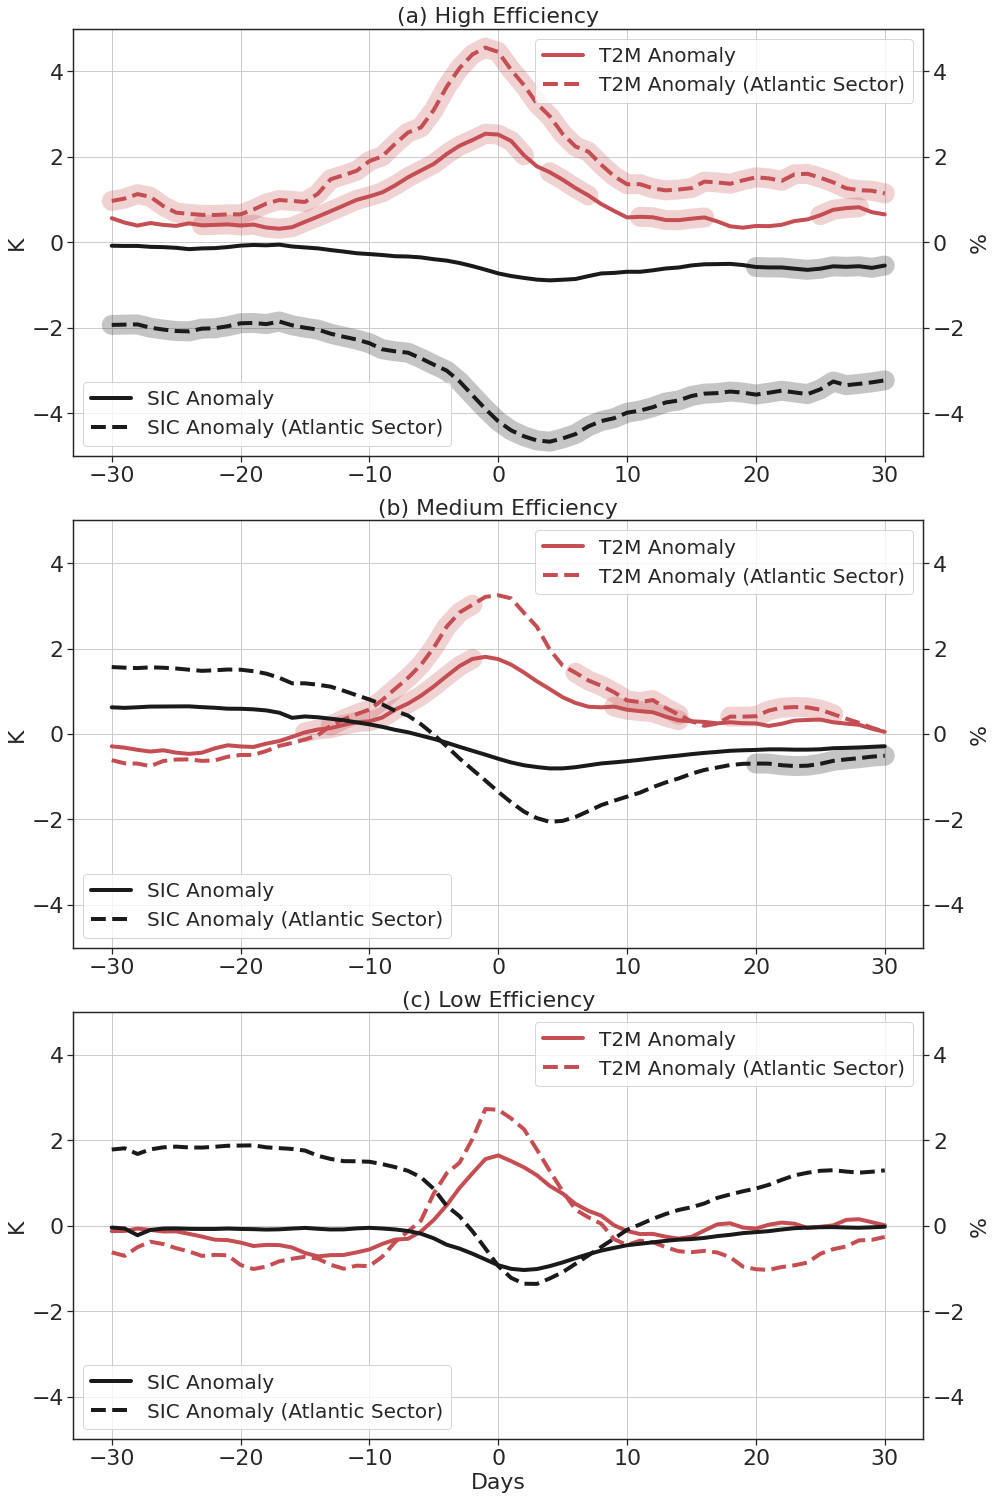

In [41]:
fig = plt.figure( figsize=(14,21) )
time=np.arange(-30,31,1)
ax = plt.subplot(311)
ax2=ax.twinx()
ax3 = plt.subplot(312)
ax4=ax3.twinx()
ax5 = plt.subplot(313)
ax6=ax5.twinx()
ax2.plot(time,comp.average(SIC_anom_comp_high_eff.sel(lat=slice(70,90)).where(mask2.FROCEAN==True)),'k',lw=4,label='SIC Anomaly')
ax2.plot(time,comp.average(SIC_anom_comp_high_eff.sel(lat=slice(70,90),lon=slice(-20,80)).where(mask2.FROCEAN==True)),'k--',lw=4,label='SIC Anomaly (Atlantic Sector)')

ax6.plot(time,comp.average(SIC_anom_comp_low_eff.sel(lat=slice(70,90)).where(mask2.FROCEAN==True)),'k-',lw=4,label='SIC Anomaly')
ax6.plot(time,comp.average(SIC_anom_comp_low_eff.sel(lat=slice(70,90),lon=slice(-20,80)).where(mask2.FROCEAN==True)),'k--',lw=4,label='SIC Anomaly (Atlantic Sector)')

ax.plot(time,comp.average(T2M_anom_comp_high_eff),'r',lw=4,label='T2M Anomaly')
ax.plot(time,comp.average(T2M_anom_comp_high_eff.sel(lon=slice(-20,80))),'r--',lw=4,label='T2M Anomaly (Atlantic Sector)')

ax5.plot(time,comp.average(T2M_anom_comp_low_eff),'r',lw=4,label='T2M Anomaly')
ax5.plot(time,comp.average(T2M_anom_comp_low_eff.sel(lon=slice(-20,80))),'r--',lw=4,label='T2M Anomaly (Atlantic Sector)')

ax4.plot(time,comp.average(SIC_anom_comp_med_eff.sel(lat=slice(70,90)).where(mask2.FROCEAN==True)),'k-',lw=4,label='SIC Anomaly')
ax4.plot(time,comp.average(SIC_anom_comp_med_eff.sel(lat=slice(70,90),lon=slice(-20,80)).where(mask2.FROCEAN==True)),'k--',lw=4,label='SIC Anomaly (Atlantic Sector)')

ax3.plot(time,comp.average(T2M_anom_comp_med_eff),'r-',lw=4,label='T2M Anomaly')
ax3.plot(time,comp.average(T2M_anom_comp_med_eff.sel(lon=slice(-20,80))),'r--',lw=4,label='T2M Anomaly (Atlantic Sector)')


ax2.plot(time,comp.average(SIC_anom_comp_high_eff.sel(lat=slice(70,90)).where(mask2.FROCEAN==True)).where(SIC_high_pc_test<.05)
         ,'k',alpha=.25,lw=20)
ax2.plot(time,comp.average(SIC_anom_comp_high_eff.sel(lat=slice(70,90),lon=slice(-20,80)).where(mask2.FROCEAN==True)).where(SIC_high_as_test<.05)
         ,'k',alpha=.25,lw=20)

ax.plot(time,comp.average(T2M_anom_comp_high_eff).where(T2M_high_pc_test<.05)
        ,'r',alpha=.25,lw=20)
ax.plot(time,comp.average(T2M_anom_comp_high_eff.sel(lon=slice(-20,80))).where(T2M_high_as_test<.05)
        ,'r',alpha=.25,lw=20)

ax4.plot(time,comp.average(SIC_anom_comp_med_eff.sel(lat=slice(70,90)).where(mask2.FROCEAN==True)).where(SIC_med_pc_test<.05)
         ,'k',alpha=.25,lw=20)
ax4.plot(time,comp.average(SIC_anom_comp_med_eff.sel(lat=slice(70,90),lon=slice(-20,80)).where(mask2.FROCEAN==True)).where(SIC_med_as_test<.05)
         ,'k',alpha=.25,lw=20)

ax3.plot(time,comp.average(T2M_anom_comp_med_eff).where(T2M_med_pc_test<.05)
         ,'r',alpha=.25,lw=20)
ax3.plot(time,comp.average(T2M_anom_comp_med_eff.sel(lon=slice(-20,80))).where(T2M_med_as_test<.05)
         ,'r',alpha=.25,lw=20)

ax.grid()
ax3.grid()
ax5.grid()
ax.set_xlabel('')
ax3.set_xlabel('')
ax5.set_xlabel('Days',fontsize=22)
ax.set_ylabel('K',fontsize=22)
ax2.set_ylabel('K',fontsize=22)
ax2.set_ylabel('%',fontsize=22)
ax3.set_ylabel('K',fontsize=22)
ax4.set_ylabel('%',fontsize=22)
ax5.set_ylabel('K',fontsize=22)
ax6.set_ylabel('%',fontsize=22)

ax.legend(loc='upper right',fontsize=20)
ax3.legend(fontsize=20)
ax5.legend(fontsize=20)
ax2.legend(loc='lower left',fontsize=20)
ax4.legend(loc='lower left',fontsize=20)
ax6.legend(loc='lower left',fontsize=20)
ax.set_ybound(-5,5)
ax2.set_ybound(-5,5)

ax3.set_ybound(-5,5)
ax4.set_ybound(-5,5)

ax5.set_ybound(-5,5)
ax6.set_ybound(-5,5)
ax.tick_params(labelsize=22)
ax2.tick_params(labelsize=22)
ax3.tick_params(labelsize=22)
ax4.tick_params(labelsize=22)
ax5.tick_params(labelsize=22)
ax6.tick_params(labelsize=22)
ax.set_title('(a) High Efficiency',fontsize=22)
ax3.set_title('(b) Medium Efficiency',fontsize=22)
ax5.set_title('(c) Low Efficiency',fontsize=22)

fig.tight_layout()
#plt.savefig('SIC_T2M_Final.pdf', bbox_inches='tight')

## Figure 4

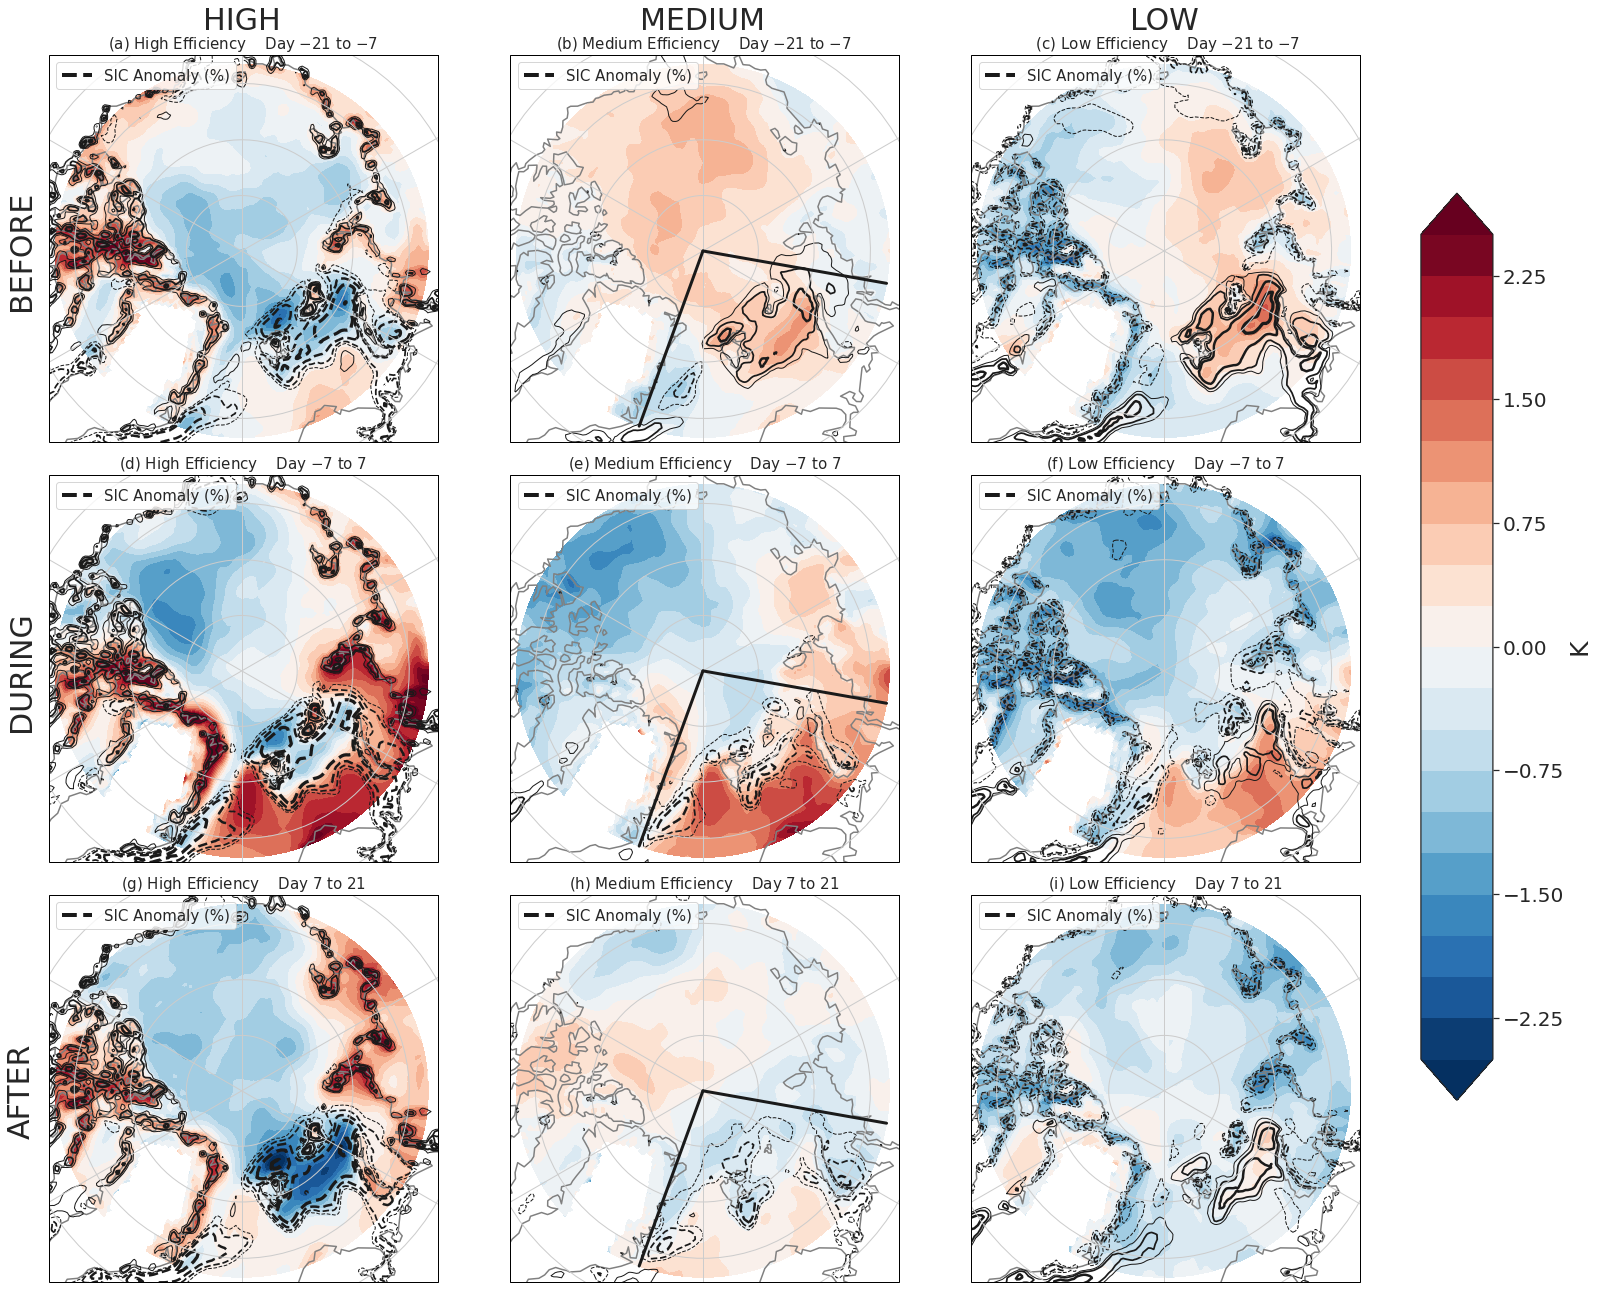

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
fig = plt.figure(figsize=(20, 18))
gs = plt.GridSpec(3, 3,
                       width_ratios=[1,1,1],
                       height_ratios=[1,1,1])

ax = fig.add_subplot(gs[0],projection=ccrs.NorthPolarStereo(central_longitude=0))
lev = np.arange(-2.5,2.75, .25)
lev2 = [-24,-12,-6,-3,-1.5,1.5,3,6,12,24]
cs = ax.coastlines(linewidth=1.5,color='gray')
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90
ax.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())
im = ax.contourf(STAB_anom.lon, STAB_anom.lat
                  ,((STAB_anom_comp_high_eff)).isel(time=slice(9,23)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')
lax = ax.contour(SIC_anom.lon, SIC_anom.lat
                  ,((SIC_anom_comp_high_eff)).isel(time=slice(9,23)).mean('time')
                  ,levels=lev2,colors='k',linewidths=[4,3.25,2.5,1.75,1,1,1.75,2.5,3.25,4],
                   transform=ccrs.PlateCarree(),extend='both')

x=[-20, -20, -20, -20]
x2=[80, 80, 80, 80]
y=[90, 90, 90, 70]

ax2 = fig.add_subplot(gs[1],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax2.coastlines(linewidth=1.5,color='gray')
gl = ax2.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90
ax2.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())
im2= ax2.contourf(STAB_anom.lon, STAB_anom.lat
                  ,((STAB_anom_comp_med_eff)).isel(time=slice(9,23)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')
lax2 = ax2.contour(SIC_anom.lon, SIC_anom.lat
                  ,((SIC_anom_comp_med_eff)).isel(time=slice(9,23)).mean('time')
                  ,levels=lev2,colors='k',linewidths=[4,3.25,2.5,1.75,1,1,1.75,2.5,3.25,4],
                   transform=ccrs.PlateCarree(),extend='both')

ax2.plot(x, y, transform=ccrs.PlateCarree(), color='k', lw=3)
ax2.plot(x2, y, transform=ccrs.PlateCarree(), color='k', lw=3)

ax3 = fig.add_subplot(gs[2],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax3.coastlines(linewidth=1.5,color='gray')
gl = ax3.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90
ax3.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())
im3 = ax3.contourf(STAB_anom.lon, STAB_anom.lat
                  ,((STAB_anom_comp_low_eff)).isel(time=slice(9,23)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')
lax3 =ax3.contour(SIC_anom.lon, SIC_anom.lat
                  ,((SIC_anom_comp_low_eff)).isel(time=slice(9,23)).mean('time')
                  ,levels=lev2,colors='k',linewidths=[4,3.25,2.5,1.75,1,1,1.75,2.5,3.25,4],
                   transform=ccrs.PlateCarree(),extend='both')


ax4 = fig.add_subplot(gs[3],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax4.coastlines(linewidth=1.5,color='gray')
gl = ax4.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90
ax4.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())
im4 = ax4.contourf(STAB_anom.lon, STAB_anom.lat
                  ,(STAB_anom_comp_high_eff).isel(time=slice(23,37)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')
lax4 =ax4.contour(SIC_anom.lon, SIC_anom.lat
                  ,((SIC_anom_comp_high_eff)).isel(time=slice(23,37)).mean('time')
                  ,levels=lev2,colors='k',linewidths=[4,3.25,2.5,1.75,1,1,1.75,2.5,3.25,4],
                   transform=ccrs.PlateCarree(),extend='both')

ax5 = fig.add_subplot(gs[4],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax5.coastlines(linewidth=1.5,color='gray')
gl = ax5.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90
ax5.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())
im5 = ax5.contourf(STAB_anom.lon, STAB_anom.lat
                  ,(STAB_anom_comp_med_eff).isel(time=slice(23,37)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')
lax5 =ax5.contour(SIC_anom.lon, SIC_anom.lat
                  ,((SIC_anom_comp_med_eff)).isel(time=slice(23,37)).mean('time')
                  ,levels=lev2,colors='k',linewidths=[4,3.25,2.5,1.75,1,1,1.75,2.5,3.25,4],
                   transform=ccrs.PlateCarree(),extend='both')
ax5.plot(x, y, transform=ccrs.PlateCarree(), color='k', lw=3)
ax5.plot(x2, y, transform=ccrs.PlateCarree(), color='k', lw=3)

ax6 = fig.add_subplot(gs[5],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax6.coastlines(linewidth=1.5,color='gray')
gl = ax6.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90
ax6.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())
im6 = ax6.contourf(STAB_anom.lon, STAB_anom.lat
                  ,(STAB_anom_comp_low_eff).isel(time=slice(23,37)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')
lax6 =ax6.contour(SIC_anom.lon, SIC_anom.lat
                  ,((SIC_anom_comp_low_eff)).isel(time=slice(23,37)).mean('time')
                  ,levels=lev2,colors='k',linewidths=[4,3.25,2.5,1.75,1,1,1.75,2.5,3.25,4],
                   transform=ccrs.PlateCarree(),extend='both')


ax7 = fig.add_subplot(gs[6],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax7.coastlines(linewidth=1.5,color='gray')
gl = ax7.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90
ax7.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())
im7 = ax7.contourf(STAB_anom.lon, STAB_anom.lat
                  ,(STAB_anom_comp_high_eff).isel(time=slice(37,51)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')
lax7 =ax7.contour(SIC_anom.lon, SIC_anom.lat
                  ,((SIC_anom_comp_high_eff)).isel(time=slice(37,51)).mean('time')
                  ,levels=lev2,colors='k',linewidths=[4,3.25,2.5,1.75,1,1,1.75,2.5,3.25,4],
                   transform=ccrs.PlateCarree(),extend='both')

ax8 = fig.add_subplot(gs[7],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax8.coastlines(linewidth=1.5,color='gray')
gl = ax8.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90
ax8.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())
im8 = ax8.contourf(STAB_anom.lon, STAB_anom.lat
                  ,(STAB_anom_comp_med_eff).isel(time=slice(37,51)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')
lax8 =ax8.contour(SIC_anom.lon, SIC_anom.lat
                  ,((SIC_anom_comp_med_eff)).isel(time=slice(37,51)).mean('time')
                  ,levels=lev2,colors='k',linewidths=[4,3.25,2.5,1.75,1,1,1.75,2.5,3.25,4],
                   transform=ccrs.PlateCarree(),extend='both')
ax8.plot(x, y, transform=ccrs.PlateCarree(), color='k', lw=3)
ax8.plot(x2, y, transform=ccrs.PlateCarree(), color='k', lw=3)

ax9 = fig.add_subplot(gs[8],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax9.coastlines(linewidth=1.5,color='gray')
gl = ax9.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90
ax9.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())
im9 = ax9.contourf(STAB_anom.lon, STAB_anom.lat
                  ,(STAB_anom_comp_low_eff).isel(time=slice(37,51)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')
lax9 =ax9.contour(SIC_anom.lon, SIC_anom.lat
                  ,((SIC_anom_comp_low_eff)).isel(time=slice(37,51)).mean('time')
                  ,levels=lev2,colors='k',linewidths=[4,3.25,2.5,1.75,1,1,1.75,2.5,3.25,4],
                   transform=ccrs.PlateCarree(),extend='both')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider7 = make_axes_locatable(ax7)
cax7 = divider7.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider8 = make_axes_locatable(ax8)
cax8 = divider8.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider9 = make_axes_locatable(ax9)
cax9 = divider9.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)

cax.axis('off')
cax2.axis('off')
cax3.axis('off')
cax4.axis('off')
cax5.axis('off')
cax6.axis('off')
cax7.axis('off')
cax8.axis('off')
cax9.axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
fig.canvas.draw()
ax.set_title('(a) High Efficiency    Day $-21$ to $-7$',fontdict={'fontsize':15})
ax2.set_title('(b) Medium Efficiency    Day $-21$ to $-7$',fontdict={'fontsize':15})
ax3.set_title(' (c) Low Efficiency    Day $-21$ to $-7$',fontdict={'fontsize':15})
ax4.set_title('(d) High Efficiency    Day $-7$ to $7$',fontdict={'fontsize':15})
ax5.set_title('(e) Medium Efficiency    Day $-7$ to $7$',fontdict={'fontsize':15})
ax6.set_title('(f) Low Efficiency    Day $-7$ to $7$',fontdict={'fontsize':15})
ax7.set_title('(g) High Efficiency    Day $7$ to $21$',fontdict={'fontsize':15})
ax8.set_title('(h) Medium Efficiency    Day $7$ to $21$',fontdict={'fontsize':15})
ax9.set_title('(i) Low Efficiency    Day $7$ to $21$',fontdict={'fontsize':15})
fig.subplots_adjust(wspace=0, hspace=0.2)

h2,_ = lax.legend_elements()
h3,_ = lax2.legend_elements()
h4,_ = lax3.legend_elements()
h5,_ = lax4.legend_elements()
h6,_ = lax5.legend_elements()
h7,_ = lax6.legend_elements()
h8,_ = lax7.legend_elements()
h9,_ = lax8.legend_elements()
h10,_ = lax9.legend_elements()
ax.legend([h2[0]], ['SIC Anomaly (%)'],loc='upper left',fontsize=15)
ax2.legend([h3[0]], ['SIC Anomaly (%)'],loc='upper left',fontsize=15)
ax3.legend([h4[0]], ['SIC Anomaly (%)'],loc='upper left',fontsize=15)
ax4.legend([h5[0]], ['SIC Anomaly (%)'],loc='upper left',fontsize=15)
ax5.legend([h6[0]], ['SIC Anomaly (%)'],loc='upper left',fontsize=15)
ax6.legend([h7[0]], ['SIC Anomaly (%)'],loc='upper left',fontsize=15)
ax7.legend([h8[0]], ['SIC Anomaly (%)'],loc='upper left',fontsize=15)
ax8.legend([h9[0]], ['SIC Anomaly (%)'],loc='upper left',fontsize=15)
ax9.legend([h10[0]], ['SIC Anomaly (%)'],loc='upper left',fontsize=15)
ax.text(-90,68,'BEFORE',va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ccrs.PlateCarree(),fontsize=30)

ax4.text(-90,68,'DURING',va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ccrs.PlateCarree(),fontsize=30)

ax7.text(-90,68,'AFTER',va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ccrs.PlateCarree(),fontsize=30)

ax.text(180,67,'HIGH',va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ccrs.PlateCarree(),fontsize=30)

ax2.text(180,67,'MEDIUM',va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ccrs.PlateCarree(),fontsize=30)

ax3.text(180,67,'LOW',va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ccrs.PlateCarree(),fontsize=30)
cbar.set_label('K',fontsize=25)
cbar.ax.tick_params(labelsize=20) 

fig.tight_layout()
#plt.savefig('stability_sic_Final.pdf', bbox_inches='tight')

## Figure 5

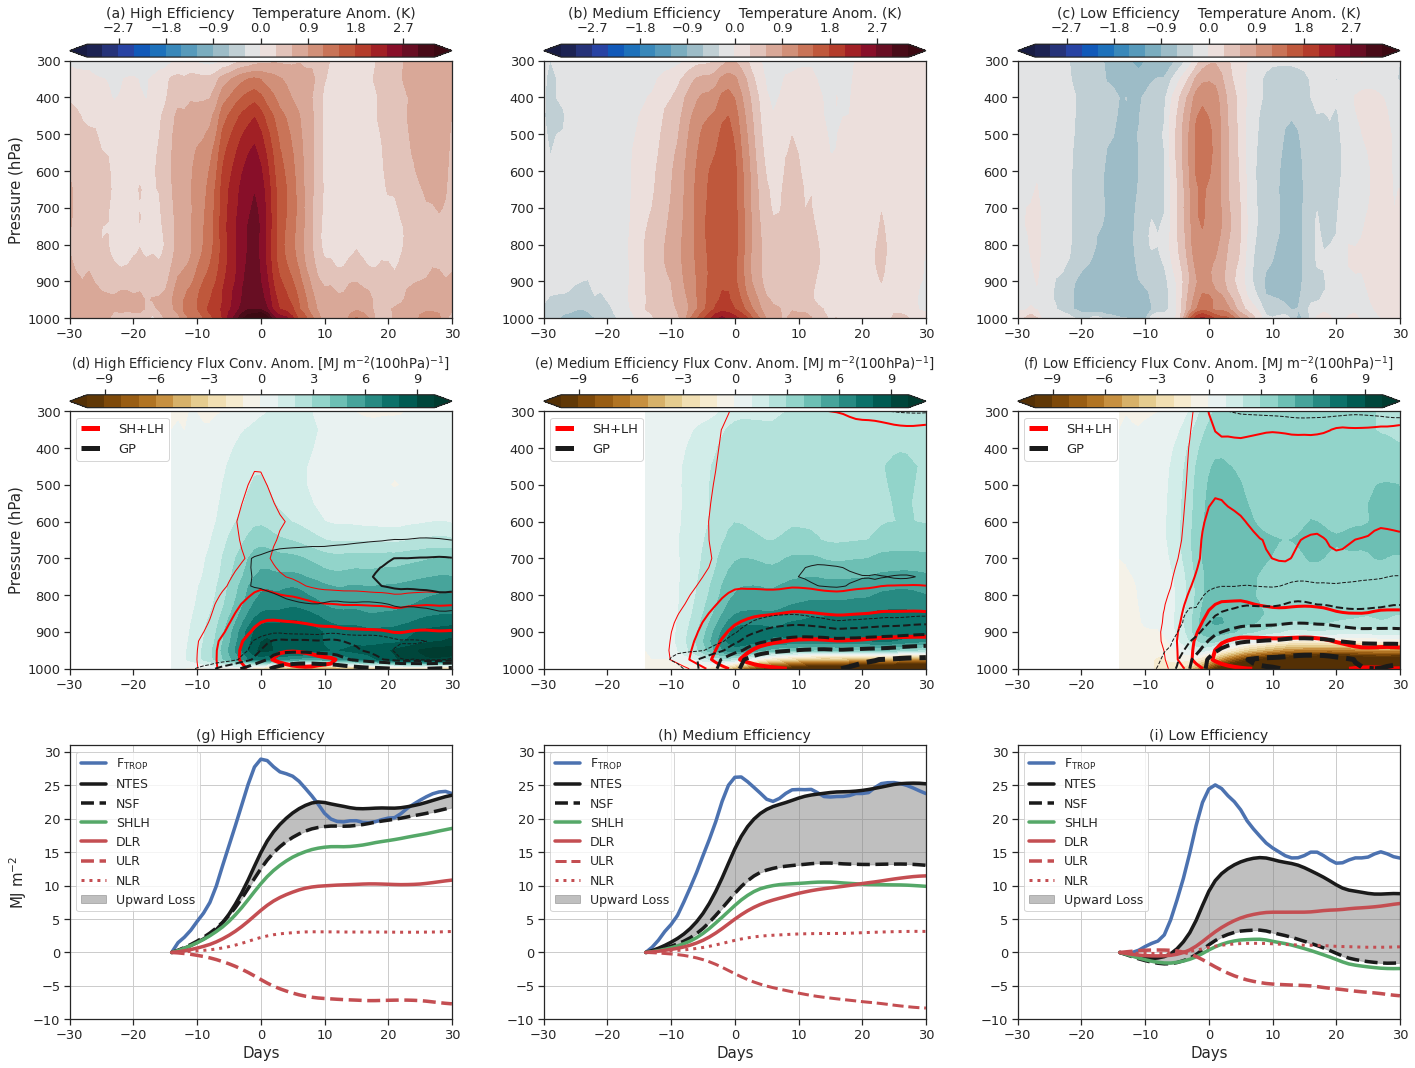

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns; sns.set(style="ticks", color_codes=True)
fig = plt.figure( figsize=(20,15) )
gs = plt.GridSpec(3, 3,
                       width_ratios=[1,1,1],
                       height_ratios=[1,1,1]
                       )
lev=merra_ET.lev
levm = lev
lev2 = np.arange(-10,11,1)
lev3 =[-32,-16,-8,-4,-2,2,4,8,16,32]

lev4 = np.arange(-3.3,3.5,.3)
lev5 = [-24,-16,-8,-4,-2,2,4,8,16,24]

lev6 = np.arange(-4,4.5,.5)
lev7 = [-2,-1,-.5,.5,1,2]

time=np.arange(-30,31,1)


ax4 = fig.add_subplot(gs[0])
im4 = ax4.contourf(time,levm,SENSIBLE_anom_comp_high_eff.transpose()/Cp
            ,cmap=palet.cmocean.diverging.Balance_19.mpl_colormap,levels=lev4,extend='both')
divider = make_axes_locatable(ax4)
cax4 = divider.append_axes('top', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4,cax=cax4,orientation='horizontal')
cax4.xaxis.set_ticks_position('top')
cbar4.ax.tick_params(labelsize=13) 

ax5 = fig.add_subplot(gs[1])
im5 = ax5.contourf(time,levm,SENSIBLE_anom_comp_med_eff.transpose()/Cp
            ,cmap=palet.cmocean.diverging.Balance_19.mpl_colormap,levels=lev4,extend='both')
divider = make_axes_locatable(ax5)
cax5 = divider.append_axes('top', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5,cax=cax5,orientation='horizontal')
cax5.xaxis.set_ticks_position('top')
cbar5.ax.tick_params(labelsize=13) 
###
ax6 = fig.add_subplot(gs[2])
im6=ax6.contourf(time,levm,SENSIBLE_anom_comp_low_eff.transpose()/Cp
            ,cmap=palet.cmocean.diverging.Balance_19.mpl_colormap,levels=lev4,extend='both')
divider = make_axes_locatable(ax6)
cax6 = divider.append_axes('top', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6,cax=cax6,orientation='horizontal')
cax6.xaxis.set_ticks_position('top')
cbar6.ax.tick_params(labelsize=13) 

ax = fig.add_subplot(gs[3])
im = ax.contourf(time[16:61],levm,integ.cumtrapz(((MSE_anom_comp_high_eff[16:61])).transpose()*comp.h(),dx=sid,initial=0)*10**-6
            ,cmap=plt.cm.BrBG,levels=lev2,extend='both')
lax=ax.contour(time[16:61],levm,integ.cumtrapz((((SH_anom_comp_high_eff+LH_anom_comp_high_eff)[16:61])).transpose()*comp.h(),dx=sid,initial=0)*10**-6
                 ,colors='red',levels=lev3,extend='both',linewidths=[5,4,3,2,1,1,2,3,4,5])
lax2=ax.contour(time[16:61],levm,integ.cumtrapz((((GP_anom_comp_high_eff)[16:61])).transpose()*comp.h(),dx=sid,initial=0)*10**-6
                 ,colors='k',levels=lev3,extend='both',linewidths=[5,4,3,2,1,1,2,3,4,5])
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)
cbar = fig.colorbar(im,cax=cax,orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbar.ax.tick_params(labelsize=13) 

ax2 = fig.add_subplot(gs[4])
im2 = ax2.contourf(time[16:61],levm,integ.cumtrapz(((MSE_anom_comp_med_eff[16:61])).transpose()*comp.h(),dx=sid,initial=0)*10**-6
            ,cmap=plt.cm.BrBG,levels=lev2,extend='both')
lax3=ax2.contour(time[16:61],levm,integ.cumtrapz((((SH_anom_comp_med_eff[16:61]+LH_anom_comp_med_eff[16:61]))).transpose()*comp.h(),dx=sid,initial=0)*10**-6
                 ,colors='red',levels=lev3,extend='both',linewidths=[5,4,3,2,1,1,2,3,4,5])
lax4=ax2.contour(time[16:61],levm,integ.cumtrapz((((GP_anom_comp_med_eff[16:61]))).transpose()*comp.h(),dx=sid,initial=0)*10**-6
                 ,colors='k',levels=lev3,extend='both',linewidths=[5,4,3,2,1,1,2,3,4,5])
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('top', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2,cax=cax2,orientation='horizontal')
cax2.xaxis.set_ticks_position('top')
cbar2.ax.tick_params(labelsize=13) 

ax3 = fig.add_subplot(gs[5])
im3=ax3.contourf(time[16:61],levm,integ.cumtrapz(((MSE_anom_comp_low_eff[16:61])).transpose()*comp.h(),dx=sid,initial=0)*10**-6
            ,cmap=plt.cm.BrBG,levels=lev2,extend='both')
lax5=ax3.contour(time[16:61],levm,integ.cumtrapz((((SH_anom_comp_low_eff+LH_anom_comp_high_eff)[16:61])).transpose()*comp.h(),dx=sid,initial=0)*10**-6
                 ,colors='red',levels=lev3,extend='both',linewidths=[5,4,3,2,1,1,2,3,4,5])
lax6=ax3.contour(time[16:61],levm,integ.cumtrapz((((GP_anom_comp_low_eff)[16:61])).transpose()*comp.h(),dx=sid,initial=0)*10**-6
                 ,colors='k',levels=lev3,extend='both',linewidths=[5,4,3,2,1,1,2,3,4,5])
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('top', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3,cax=cax3,orientation='horizontal')
cax3.xaxis.set_ticks_position('top')
cbar3.ax.tick_params(labelsize=13) 

ax7 = fig.add_subplot(gs[6])
ax7.plot(time[16:61],integ.cumtrapz(comp.integrate_trop(MSE_anom_comp_high_eff*C/A)[16:61],dx=sid,initial=0)*10**-6,'b',lw=3.5,label='F$_{\mathrm{TROP}}$')
ax7.plot(time[16:61],integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)*10**-6,'k',lw=3.5,label='NTES')
ax7.plot(time[16:61],integ.cumtrapz((NSF_anom_comp_high_eff)[16:61],dx=sid,initial=0)*10**-6,'k--',lw=3.5,label='NSF')
ax7.plot(time[16:61],integ.cumtrapz((SHLH_anom_comp_high_eff)[16:61],dx=sid,initial=0)*10**-6,'g',lw=3.5,label='SHLH')
ax7.plot(time[16:61],integ.cumtrapz((DLR_anom_comp_high_eff)[16:61],dx=sid,initial=0)*10**-6,'r',lw=3.5,label='DLR')
ax7.plot(time[16:61],integ.cumtrapz((ULR_anom_comp_high_eff)[16:61],dx=sid,initial=0)*10**-6,'r--',lw=3.5,label='ULR')
ax7.plot(time[16:61],integ.cumtrapz((ULR_anom_comp_high_eff+DLR_anom_comp_high_eff)[16:61],dx=sid,initial=0)*10**-6,'r',ls='dotted',lw=3,label='NLR')
ax7.fill_between(time[16:61],integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)*10**-6,
                integ.cumtrapz((NSF_anom_comp_high_eff)[16:61],dx=sid,initial=0)*10**-6,color='gray',alpha=.5,label='Upward Loss')

ax8 = fig.add_subplot(gs[7])
ax8.plot(time[16:61],integ.cumtrapz(comp.integrate_trop(MSE_anom_comp_med_eff*C/A)[16:61],dx=sid,initial=0)*10**-6,'b',lw=3.5,label='F$_{\mathrm{TROP}}$')
ax8.plot(time[16:61],integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)*10**-6,'k',lw=3.5,label='NTES')
ax8.plot(time[16:61],integ.cumtrapz((NSF_anom_comp_med_eff)[16:61],dx=sid,initial=0)*10**-6,'k--',lw=3.5,label='NSF')
ax8.plot(time[16:61],integ.cumtrapz((SHLH_anom_comp_med_eff)[16:61],dx=sid,initial=0)*10**-6,'g',lw=3.5,label='SHLH')
ax8.plot(time[16:61],integ.cumtrapz((DLR_anom_comp_med_eff)[16:61],dx=sid,initial=0)*10**-6,'r',lw=3.5,label='DLR')
ax8.plot(time[16:61],integ.cumtrapz((ULR_anom_comp_med_eff)[16:61],dx=sid,initial=0)*10**-6,'r--',lw=3,label='ULR')
ax8.plot(time[16:61],integ.cumtrapz((ULR_anom_comp_med_eff+DLR_anom_comp_med_eff)[16:61],dx=sid,initial=0)*10**-6,'r',ls='dotted',lw=3,label='NLR')
ax8.fill_between(time[16:61],integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)*10**-6,
                integ.cumtrapz((NSF_anom_comp_med_eff)[16:61],dx=sid,initial=0)*10**-6,color='gray',alpha=.5,label='Upward Loss')

ax9 = fig.add_subplot(gs[8])
ax9.plot(time[16:61],integ.cumtrapz(comp.integrate_trop(MSE_anom_comp_low_eff*C/A)[16:61],dx=sid,initial=0)*10**-6,'b',lw=3.5,label='F$_{\mathrm{TROP}}$')
ax9.plot(time[16:61],integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)*10**-6,'k',lw=3.5,label='NTES')
ax9.plot(time[16:61],integ.cumtrapz((NSF_anom_comp_low_eff)[16:61],dx=sid,initial=0)*10**-6,'k--',lw=3.5,label='NSF')
ax9.plot(time[16:61],integ.cumtrapz((SHLH_anom_comp_low_eff)[16:61],dx=sid,initial=0)*10**-6,'g',lw=3.5,label='SHLH')
ax9.plot(time[16:61],integ.cumtrapz((DLR_anom_comp_low_eff)[16:61],dx=sid,initial=0)*10**-6,'r',lw=3.5,label='DLR')
ax9.plot(time[16:61],integ.cumtrapz((ULR_anom_comp_low_eff)[16:61],dx=sid,initial=0)*10**-6,'r--',lw=3.5,label='ULR')
ax9.plot(time[16:61],integ.cumtrapz((ULR_anom_comp_low_eff+DLR_anom_comp_low_eff)[16:61],dx=sid,initial=0)*10**-6,'r',ls='dotted',lw=3,label='NLR')
ax9.fill_between(time[16:61],integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)*10**-6,
                integ.cumtrapz((NSF_anom_comp_low_eff)[16:61],dx=sid,initial=0)*10**-6,color='gray',alpha=.5,label='Upward Loss')

ax.axes.invert_yaxis()
ax2.axes.invert_yaxis()
ax3.axes.invert_yaxis()
ax4.axes.invert_yaxis()
ax5.axes.invert_yaxis()
ax6.axes.invert_yaxis()
ax.set_ylabel('Pressure (hPa)',fontsize=15)
ax4.set_ylabel('Pressure (hPa)',fontsize=15)
ax7.set_ylabel('MJ m$^{-2}$',fontsize=15)
ax7.set_xlabel('Days',fontsize=15)
ax8.set_xlabel('Days',fontsize=15)
ax9.set_xlabel('Days',fontsize=15)
ax.set_ybound(1000,300)
ax2.set_ybound(1000,300)
ax3.set_ybound(1000,300)
ax4.set_ybound(1000,300)
ax5.set_ybound(1000,300)
ax6.set_ybound(1000,300)

cbar.set_label('(d) High Efficiency Flux Conv. Anom. [MJ m$^{-2}$(100hPa)$^{-1}$]',fontsize=13.25)
cbar2.set_label('(e) Medium Efficiency Flux Conv. Anom. [MJ m$^{-2}$(100hPa)$^{-1}$]',fontsize=13.25)
cbar3.set_label('(f) Low Efficiency Flux Conv. Anom. [MJ m$^{-2}$(100hPa)$^{-1}$]',fontsize=13.25)
cbar4.set_label('(a) High Efficiency    Temperature Anom. (K)',fontsize=14)
cbar5.set_label('(b) Medium Efficiency    Temperature Anom. (K)',fontsize=14)
cbar6.set_label('(c) Low Efficiency    Temperature Anom. (K)',fontsize=14)
ax7.set_title('(g) High Efficiency',fontdict={'fontsize':14})
ax8.set_title('(h) Medium Efficiency',fontdict={'fontsize':14})
ax9.set_title('(i) Low Efficiency',fontdict={'fontsize':14})
cax.xaxis.set_label_position('top')
cax2.xaxis.set_label_position('top')
cax3.xaxis.set_label_position('top')
cax4.xaxis.set_label_position('top')
cax5.xaxis.set_label_position('top')
cax6.xaxis.set_label_position('top')
ax7.legend(fontsize=12.5)
ax7.margins(0)
ax7.set_ybound(-10,31)
ax7.grid()

ax8.legend(fontsize=12.5)
ax8.margins(0)
ax8.set_ybound(-10,31)
ax8.grid()

ax9.legend(fontsize=12.5)
ax9.margins(0)
ax9.set_ybound(-10,31)
ax9.grid()

h2,_ = lax.legend_elements()
h3,_ = lax2.legend_elements()
ax.legend([h2[0],h3[0]], ['SH+LH','GP'],loc='upper left',fontsize=13)
h4,_ = lax3.legend_elements()
h5,_ = lax4.legend_elements()
ax2.legend([h4[0],h5[0]], ['SH+LH','GP'],loc='upper left',fontsize=13)
h6,_ = lax5.legend_elements()
h7,_ = lax6.legend_elements()
ax3.legend([h6[0],h7[0]], ['SH+LH','GP'],loc='upper left',fontsize=13)

ax.set_xbound(-30,30)
ax2.set_xbound(-30,30)
ax3.set_xbound(-30,30)
ax7.set_xbound(-30,30)
ax8.set_xbound(-30,30)
ax9.set_xbound(-30,30)

ax.tick_params(labelsize=13)
ax2.tick_params(labelsize=13)
ax3.tick_params(labelsize=13)
ax4.tick_params(labelsize=13)
ax5.tick_params(labelsize=13)
ax6.tick_params(labelsize=13)
ax7.tick_params(labelsize=13)
ax8.tick_params(labelsize=13)
ax9.tick_params(labelsize=13)

fig.tight_layout()
#plt.savefig('vert_comparison_Final.pdf', bbox_inches='tight')

In [44]:
print('cumulative Ftrop anomaly in MJ/m2 at day 0:' +' high-efficiency: {}, medium-efficiency: {}, and low-efficienyc: {}'.format(
    (integ.cumtrapz(comp.integrate_trop(MSE_anom_comp_high_eff*C/A)[16:61],dx=sid,initial=0)[14]*10**-6).round(1),
(integ.cumtrapz(comp.integrate_trop(MSE_anom_comp_med_eff*C/A)[16:61],dx=sid,initial=0)[14]*10**-6).round(1),
(integ.cumtrapz(comp.integrate_trop(MSE_anom_comp_low_eff*C/A)[16:61],dx=sid,initial=0)[14]*10**-6).round(1)))

cumulative Ftrop anomaly in MJ/m2 at day 0: high-efficiency: 28.9, medium-efficiency: 26.2, and low-efficienyc: 24.5


## Figure 6

### Time integrated Arctic energy budget between days -14 to +10
Dataframes are used for plotting with seaborn

In [45]:
df_high = pd.DataFrame({'DLR':np.array([integ.cumtrapz((DLR_anom_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(DLR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(DLR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff>.15,SIC_comp_high_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(DLR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_high_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6]),
            
                   'ULR':np.array([integ.cumtrapz((ULR_anom_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(ULR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(ULR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff>.15,SIC_comp_high_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(ULR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_high_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6]),
                  
                   'SHLH':np.array([integ.cumtrapz((SHLH_anom_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff>.15,SIC_comp_high_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_high_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6]),
                   'Upward Loss':np.array([integ.cumtrapz((NTES_comp_high_eff-NSF_anom_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6,0,0,0])})

df_med = pd.DataFrame({'DLR':np.array([integ.cumtrapz((DLR_anom_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(DLR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(DLR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff>.15,SIC_comp_med_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(DLR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_med_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6]),
            
                   'ULR':np.array([integ.cumtrapz((ULR_anom_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(ULR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(ULR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff>.15,SIC_comp_med_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(ULR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_med_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6]),
                  
                   'SHLH':np.array([integ.cumtrapz((SHLH_anom_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff>.15,SIC_comp_med_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_med_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6]),
                   'Upward Loss':np.array([integ.cumtrapz((NTES_comp_med_eff-NSF_anom_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6,0,0,0])})

df_low = pd.DataFrame({'DLR':np.array([integ.cumtrapz((DLR_anom_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(DLR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(DLR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff>.15,SIC_comp_low_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(DLR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_low_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6]),
            
                   'ULR':np.array([integ.cumtrapz((ULR_anom_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(ULR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(ULR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff>.15,SIC_comp_low_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(ULR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_low_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6]),
                  
                   'SHLH':np.array([integ.cumtrapz((SHLH_anom_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff>.15,SIC_comp_low_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6,
                    integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_low_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6]),
                   'Upward Loss':np.array([integ.cumtrapz((NTES_comp_low_eff-NSF_anom_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6,0,0,0])})

df_p_high = pd.DataFrame({'DLR':np.array([(integ.cumtrapz((DLR_anom_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                          /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(DLR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                          /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(DLR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff>.15,SIC_comp_high_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                         /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(DLR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_high_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                         /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6)])*100,
            
                   'ULR':np.array([(integ.cumtrapz((ULR_anom_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(ULR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(ULR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff>.15,SIC_comp_high_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                  /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(ULR_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_high_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                  /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6)])*100,
                  
                   'SHLH':np.array([(integ.cumtrapz((SHLH_anom_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                    /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                    /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_high_eff>.15,SIC_comp_high_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_high_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_high_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6)])*100,
                          
                   'Upward Loss':np.array([(integ.cumtrapz((NTES_comp_high_eff-NSF_anom_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                           /(integ.cumtrapz((NTES_comp_high_eff)[16:61],dx=sid,initial=0)[24]*10**-6),0,0,0])*100})

df_p_med = pd.DataFrame({'DLR':np.array([(integ.cumtrapz((DLR_anom_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                         /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(DLR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                         /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(DLR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff>.15,SIC_comp_med_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                        /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(DLR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_med_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                        /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6)])*100,
            
                   'ULR':np.array([(integ.cumtrapz((ULR_anom_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(ULR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(ULR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff>.15,SIC_comp_med_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                  /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(ULR_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_med_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                  /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6)])*100,
                  
                   'SHLH':np.array([(integ.cumtrapz((SHLH_anom_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                    /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                    /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_med_eff>.15,SIC_comp_med_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_med_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_med_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6)])*100,
                         
                   'Upward Loss':np.array([(integ.cumtrapz((NTES_comp_med_eff-NSF_anom_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                           /(integ.cumtrapz((NTES_comp_med_eff)[16:61],dx=sid,initial=0)[24]*10**-6),0,0,0])*100})

df_p_low = pd.DataFrame({'DLR':np.array([(integ.cumtrapz((DLR_anom_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                       /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(DLR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                       /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(DLR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff>.15,SIC_comp_low_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                      /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(DLR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_low_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                      /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6)])*100,
            
                   'ULR':np.array([(integ.cumtrapz((ULR_anom_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(ULR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(ULR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff>.15,SIC_comp_low_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                  /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(ULR_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_low_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                  /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6)])*100,
                  
                   'SHLH':np.array([(integ.cumtrapz((SHLH_anom_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                    /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff<.15,mask3.FROCEAN==False)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                    /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_and(SIC_comp_low_eff>.15,SIC_comp_low_eff<.98)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),
                    (integ.cumtrapz((comp.average(SHLH_spatial_anom_comp_low_eff
                                                 .where(xr.ufuncs.logical_or(SIC_comp_low_eff>.98,mask3.FROCEAN==True)).fillna(0)))[16:61],dx=sid,initial=0)[24]*10**-6)
                                   /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6)])*100,
                       
                   'Upward Loss':np.array([(integ.cumtrapz((NTES_comp_low_eff-NSF_anom_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6)
                                           /(integ.cumtrapz((NTES_comp_low_eff)[16:61],dx=sid,initial=0)[24]*10**-6),0,0,0])*100})

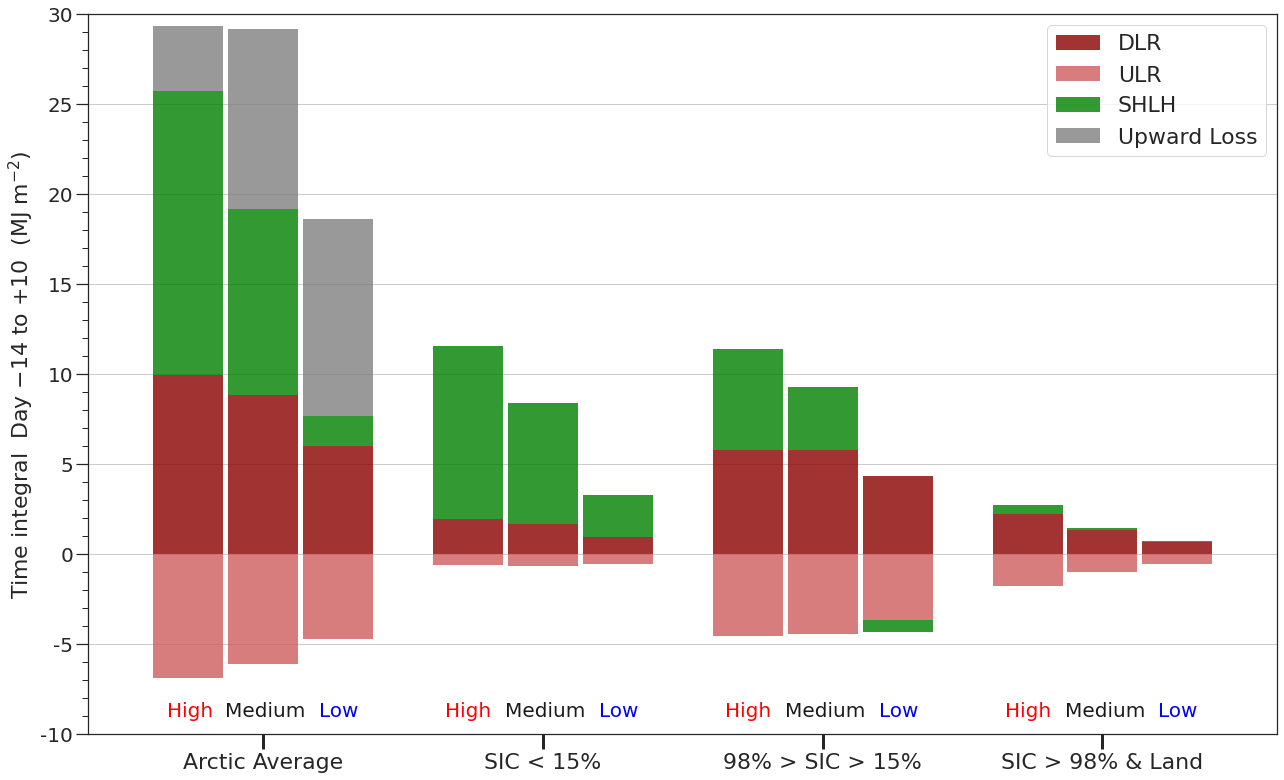

<Figure size 1296x864 with 0 Axes>

In [46]:
ax = df_high.plot.bar(position=2.07,width=.25,stacked=True, figsize=(18, 11),color=['darkred','indianred','green','gray'],edgecolor='k',lw=0,alpha=.8)
df_med.plot.bar(position=1,width=.25,stacked=True, figsize=(18, 11),color=['darkred','indianred','green','gray'],edgecolor='k',lw=0,ax=ax,legend=False,alpha=.8)
df_low.plot.bar(position=-.07,width=.25,stacked=True, figsize=(18, 11),color=['darkred','indianred','green','gray'],edgecolor='k',lw=0,ax=ax,legend=False,alpha=.8)

ax2 = df_p_high.plot.bar(position=2,width=.25,stacked=True, figsize=(18, 12))
df_p_med.plot.bar(position=1,width=.25,stacked=True, figsize=(18, 12),ax=ax2)
df_p_low.plot.bar(position=0,width=.25,stacked=True, figsize=(18, 12),ax=ax2)

# .patches is everything inside of the chart
for rect,rect2 in zip(ax.patches,ax2.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    height2 = rect2.get_height()
    width2 = rect2.get_width()
    x2 = rect2.get_x()
    y2 = rect2.get_y()
    
    # The height of the bar is the data value and can be used as the label
    #label_text = f'{height2:.1f}%'
    label_text = f'{height2:.1f}%'
    label_text2 = f'{height:.1f}'
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2
    label_x2 = x  -(width/6)
    label_y2 = y + height / 2

    # only plot labels with non-zero height
#    if np.absolute(height2) > 2:
#        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=20,color='w')

[ax.text(x,y,'High',rotation=0,fontsize=20,color='red') for x,y in zip([-.47,.525,1.525,2.525],[-9,-9,-9,-9])]
[ax.text(x,y,'Medium',rotation=0,fontsize=20,color='k') for x,y in zip([-.260,.74,1.74,2.74],[-9,-9,-9,-9])]
[ax.text(x,y,'Low',rotation=0,fontsize=20,color='blue') for x,y in zip([.075,1.075,2.075,3.075],[-9,-9,-9,-9])]
# move the legend
ax.legend(['DLR','ULR','SHLH','Upward Loss'],loc='upper right',fontsize=22)

# add labels
ax.set_ylabel('Time integral  Day $-14$ to $+10$  (MJ m$^{-2}$)' , fontsize=22)
#ax.set_xlabel("Event", fontsize=18)
ax.set_xticklabels(['Arctic Average','SIC < 15%','98% > SIC > 15%', 'SIC > 98% & Land'],
                    rotation=0, fontsize=22)
ax.set_yticks(np.arange(-10,30,1),minor=True)
ax.set_yticklabels(np.arange(-10,35,5),fontsize=20)
ax.set_xticks([-.125,.875,1.875,2.875])
#ax.set_xticks([-.55,.305,.45,1.3,1.45,2.30],'minor')
ax.tick_params(axis='x',which='minor',direction='in',length=15,width=3)
ax.tick_params(axis='x',which='major',direction='out',length=15,width=3)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='y',which='minor',direction='out',length=6)
ax.tick_params(axis='y',which='major',direction='out',length=11.75)
ax.set_ybound(-10,30)
ax.set_xbound(-.75,3.5)
ax2.remove()
fig = ax.get_figure()
fig.tight_layout()
ax.grid(axis='y')
#fig.savefig('Arctic_energy_budget_Final2.pdf', bbox_inches='tight')

## Unpublished Figure 
* Spatial plots of the Arctic energy budget
* over land and where SIC > .98, DLR changes dominate; however, these areas are associated with relatively small anomalies

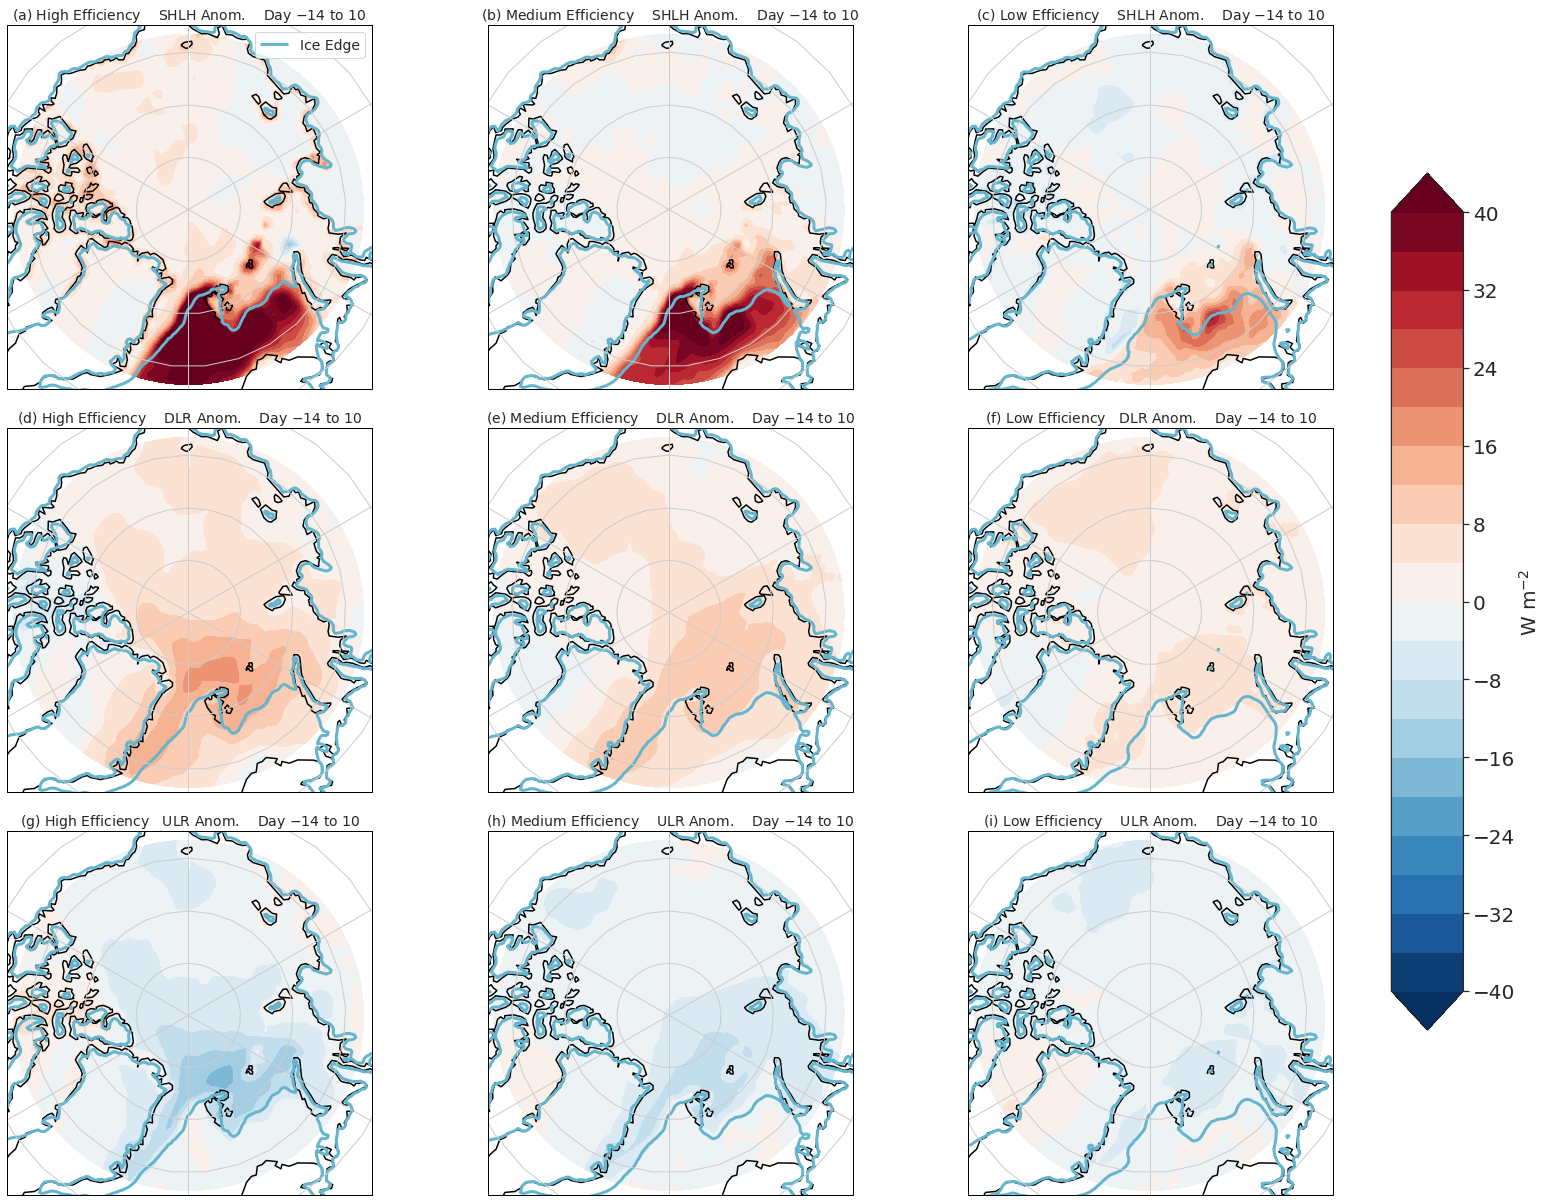

In [47]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(20, 17))
gs = plt.GridSpec(3, 3,
                       width_ratios=[1,1,1],
                       height_ratios=[1,1,1]
                       )
ax = fig.add_subplot(gs[0],projection=ccrs.NorthPolarStereo(central_longitude=0))
lev = np.arange(-40,44, 4)
cs = ax.coastlines(linewidth=1.5)
ax.gridlines()
ax.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax = ax.contourf(CLDH.lon, CLDH.lat
                  ,((SHLH_spatial_anom_comp_high_eff)).isel(time=slice(16,41)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax2 = fig.add_subplot(gs[1],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax2.coastlines(linewidth=1.5)
ax2.gridlines()
ax2.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax2 = ax2.contourf(CLDH.lon, CLDH.lat
                  ,((SHLH_spatial_anom_comp_med_eff)).isel(time=slice(16,41)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax3 = fig.add_subplot(gs[2],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax3.coastlines(linewidth=1.5)
ax3.gridlines()
ax3.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax3 = ax3.contourf(CLDH.lon, CLDH.lat
                  ,((SHLH_spatial_anom_comp_low_eff)).isel(time=slice(16,41)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax4 = fig.add_subplot(gs[3],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax4.coastlines(linewidth=1.5)
ax4.gridlines()
ax4.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax4 = ax4.contourf(CLDH.lon, CLDH.lat
                  ,((DLR_spatial_anom_comp_high_eff)).isel(time=slice(16,41)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax5 = fig.add_subplot(gs[4],projection=ccrs.NorthPolarStereo(central_longitude=0))
#lev = np.arange(-12,14, 2)
#lev2 = np.arange(0,1.5, .5)
cs = ax5.coastlines(linewidth=1.5)
ax5.gridlines()
ax5.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax5 = ax5.contourf(CLDH.lon, CLDH.lat
                  ,((DLR_spatial_anom_comp_med_eff)).isel(time=slice(16,41)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax6 = fig.add_subplot(gs[5],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax6.coastlines(linewidth=1.5)
ax6.gridlines()
ax6.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax6 = ax6.contourf(CLDH.lon, CLDH.lat
                  ,((DLR_spatial_anom_comp_low_eff)).isel(time=slice(16,41)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax7 = fig.add_subplot(gs[6],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax7.coastlines(linewidth=1.5)
ax7.gridlines()
ax7.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax7 = ax7.contourf(CLDH.lon, CLDH.lat
                  ,((ULR_spatial_anom_comp_high_eff)).isel(time=slice(16,41)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax8 = fig.add_subplot(gs[7],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax8.coastlines(linewidth=1.5)
ax8.gridlines()
ax8.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax8 = ax8.contourf(CLDH.lon, CLDH.lat
                  ,((ULR_spatial_anom_comp_med_eff)).isel(time=slice(16,41)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax9 = fig.add_subplot(gs[8],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax9.coastlines(linewidth=1.5)
ax9.gridlines()
ax9.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax9 = ax9.contourf(CLDH.lon, CLDH.lat
                  ,((ULR_spatial_anom_comp_low_eff)).isel(time=slice(16,41)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

lax=ax.contour(SIC_anom.lon, SIC_anom.lat
                  ,SIC_comp_high_eff.isel(time=slice(16,41)).mean('time')
                  ,levels=[.15],colors='c',linewidths=[3],
                   transform=ccrs.PlateCarree(),extend='both',label='Ice Edge')

ax2.contour(SIC_anom.lon, SIC_anom.lat
                  ,SIC_comp_med_eff.isel(time=slice(16,41)).mean('time')
                  ,levels=[.15],colors='c',linewidths=[3],
                   transform=ccrs.PlateCarree(),extend='both')

ax3.contour(SIC_anom.lon, SIC_anom.lat
                  ,SIC_comp_low_eff.isel(time=slice(16,41)).mean('time')
                  ,levels=[.15],colors='c',linewidths=[3],
                   transform=ccrs.PlateCarree(),extend='both')

ax4.contour(SIC_anom.lon, SIC_anom.lat
                  ,SIC_comp_high_eff.isel(time=slice(16,41)).mean('time')
                  ,levels=[.15],colors='c',linewidths=[3],
                   transform=ccrs.PlateCarree(),extend='both')

ax5.contour(SIC_anom.lon, SIC_anom.lat
                  ,SIC_comp_med_eff.isel(time=slice(16,41)).mean('time')
                  ,levels=[.15],colors='c',linewidths=[3],
                   transform=ccrs.PlateCarree(),extend='both')

ax6.contour(SIC_anom.lon, SIC_anom.lat
                  ,SIC_comp_low_eff.isel(time=slice(16,41)).mean('time')
                  ,levels=[.15],colors='c',linewidths=[3],
                   transform=ccrs.PlateCarree(),extend='both')

ax7.contour(SIC_anom.lon, SIC_anom.lat
                  ,SIC_comp_high_eff.isel(time=slice(16,41)).mean('time')
                  ,levels=[.15],colors='c',linewidths=[3],
                   transform=ccrs.PlateCarree(),extend='both')

ax8.contour(SIC_anom.lon, SIC_anom.lat
                  ,SIC_comp_med_eff.isel(time=slice(16,41)).mean('time')
                  ,levels=[.15],colors='c',linewidths=[3],
                   transform=ccrs.PlateCarree(),extend='both')

ax9.contour(SIC_anom.lon, SIC_anom.lat
                  ,SIC_comp_low_eff.isel(time=slice(16,41)).mean('time')
                  ,levels=[.15],colors='c',linewidths=[3],
                   transform=ccrs.PlateCarree(),extend='both')
h,_ = lax.legend_elements()
ax.legend([h[0]], ['Ice Edge'],loc='upper right',fontsize=14)

#23,30

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar=fig.colorbar(cax6, cax=cbar_ax)
fig.canvas.draw()
cbar.set_label('W m$^{-2}$',fontsize=20)
cbar.set_ticks(np.arange(-40,44,8))
cbar.ax.tick_params(labelsize=20) 
ax.set_title('(a) High Efficiency    SHLH Anom.    Day $-14$ to $10$',fontsize=14)
ax2.set_title('(b) Medium Efficiency    SHLH Anom.    Day $-14$ to $10$',fontsize=14)
ax3.set_title('(c) Low Efficiency    SHLH Anom.    Day $-14$ to $10$',fontsize=14)
ax4.set_title('(d) High Efficiency    DLR Anom.    Day $-14$ to $10$',fontsize=14)
ax5.set_title('(e) Medium Efficiency    DLR Anom.    Day $-14$ to $10$',fontsize=14)
ax6.set_title('(f) Low Efficiency   DLR Anom.    Day $-14$ to $10$',fontsize=14)
ax7.set_title('(g) High Efficiency   ULR Anom.    Day $-14$ to $10$',fontsize=14)
ax8.set_title('(h) Medium Efficiency    ULR Anom.    Day $-14$ to $10$',fontsize=14)
ax9.set_title('(i) Low Efficiency    ULR Anom.    Day $-14$ to $10$',fontsize=14)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider7 = make_axes_locatable(ax7)
cax7 = divider7.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider8 = make_axes_locatable(ax8)
cax8 = divider8.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider9 = make_axes_locatable(ax9)
cax9 = divider9.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)

cax.axis('off')
cax2.axis('off')
cax3.axis('off')
cax4.axis('off')
cax5.axis('off')
cax6.axis('off')
cax7.axis('off')
cax8.axis('off')
cax9.axis('off')
fig.tight_layout()
#fig.savefig('Arctic_energy_budget_alternate2.pdf', bbox_inches='tight')

## Figure 7

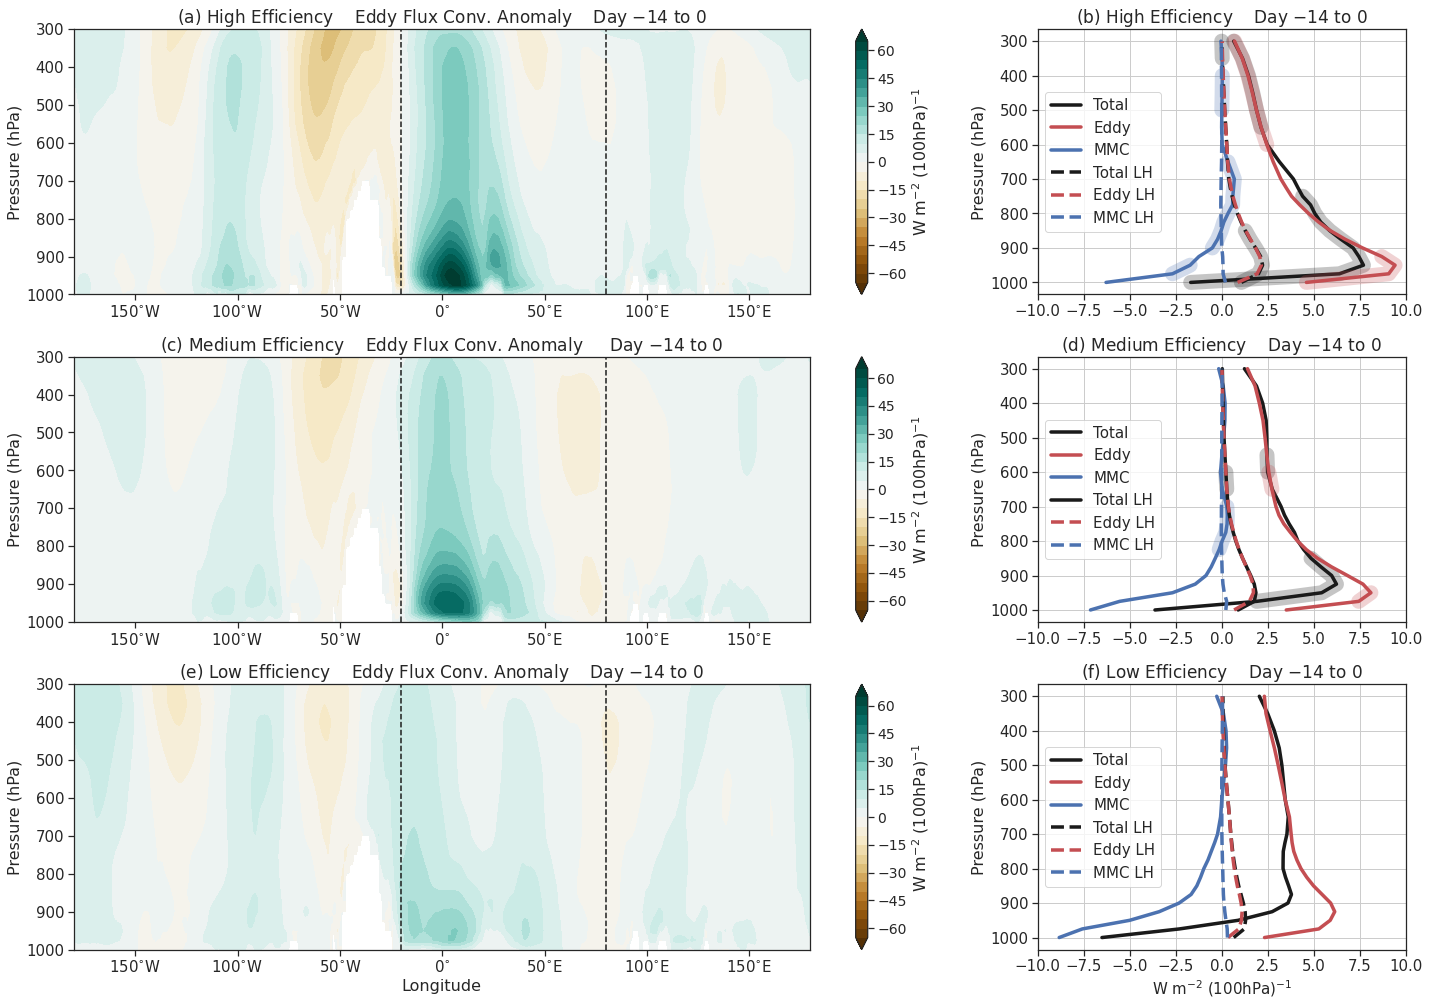

In [48]:
fig = plt.figure(figsize=(20, 18))
gs = plt.GridSpec(4, 2,
                       width_ratios=[1,.4],
                       height_ratios=[1,1,1,1]
                       )
array1 = EDDY_MSE_anom_comp_high_eff
array2 = EDDY_MSE_anom_comp_med_eff
array3 = EDDY_MSE_anom_comp_low_eff
array4 = MSE_anom_comp_high_eff
array5 = MSE_anom_comp_med_eff
array6 = MSE_anom_comp_low_eff

LH1 = EDDY_LH_anom_comp_high_eff
LH2 = EDDY_LH_anom_comp_med_eff
LH3 = EDDY_LH_anom_comp_low_eff
LH4 = LH_anom_comp_high_eff
LH5 = LH_anom_comp_med_eff
LH6 = LH_anom_comp_low_eff

SH1 = EDDY_GP_anom_comp_high_eff
SH2 = EDDY_GP_anom_comp_med_eff
SH3 = EDDY_GP_anom_comp_low_eff
SH4 = GP_anom_comp_high_eff
SH5 = GP_anom_comp_med_eff
SH6 = GP_anom_comp_low_eff
day_range = slice(16,30)
ax = fig.add_subplot(gs[0])
lev2=np.arange(-65,70,5)
lev3=lev3 =[-80,-40,-20,-10,10,20,40,80]

im=((array1).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time'])*comp.h()*mask_EDDY).plot.contourf(y='lev', yincrease=False,ax=ax,cmap=plt.cm.BrBG,levels=lev2,extend='both',add_colorbar=False)

cbar=plt.colorbar(im)
cbar.set_label('W m$^{-2}$ (100hPa)$^{-1}$',fontsize=16)
cbar.ax.tick_params(labelsize=14) 

ax2 = fig.add_subplot(gs[1])
(((array4)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax2,color='k',lw=3.5,ls='-',label='Total')

(((array4)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).where(sp.ttest_ind(((MSE_anom_comp_event_high_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h(),((MSE_anom_comp_event_low_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).pvalue<.05).plot(y='lev', yincrease=False,ax=ax2,color='k',lw=15,alpha=.25,label='')

(((array4-array1.mean('lon'))).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).where(sp.ttest_ind(((MSE_anom_comp_event_high_eff-EDDY_MSE_comp_event_high_eff.mean('lon'))).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h(),((MSE_anom_comp_event_low_eff-EDDY_MSE_comp_event_low_eff.mean('lon'))).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).pvalue<.05).plot(y='lev', yincrease=False,ax=ax2,color='b',lw=15,alpha=.25,label='')

(((LH4)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).where(sp.ttest_ind(((LH_anom_comp_event_high_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h(),((LH_anom_comp_event_low_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).pvalue<.05).plot(y='lev', yincrease=False,ax=ax2,color='k',lw=15,alpha=.25,label='')

(((array1)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).where(sp.ttest_ind(((EDDY_MSE_comp_event_high_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h(),((EDDY_MSE_comp_event_low_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).pvalue<.05).plot(y='lev', yincrease=False,ax=ax2,color='r',lw=15,alpha=.25,label='')

((array1).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).plot(y='lev', yincrease=False,ax=ax2,color='r',lw=3.5,ls='-',label='Eddy')
(((array4)-array1.mean('lon')).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax2,color='b',lw=3.5,ls='-',label='MMC')

(((LH4)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax2,color='k',lw=3.5,ls='--',label='Total LH')
((LH1).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).plot(y='lev', yincrease=False,ax=ax2,color='r',lw=3.5,ls='--',label='Eddy LH')
(((LH4)-LH1.mean('lon')).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax2,color='b',lw=3.5,ls='--',label='MMC LH')

ax4 = fig.add_subplot(gs[2])
im=((array2).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time'])*comp.h()*mask_EDDY).plot.contourf(y='lev', yincrease=False,ax=ax4,cmap=plt.cm.BrBG,levels=lev2,extend='both',add_colorbar=False)

cbar=plt.colorbar(im)
cbar.set_label('W m$^{-2}$ (100hPa)$^{-1}$',fontsize=16)
cbar.ax.tick_params(labelsize=14) 

ax5 = fig.add_subplot(gs[3])
(((array5)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax5,color='k',lw=3.5,ls='-',label='Total')

(((array5)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).where(sp.ttest_ind(((MSE_anom_comp_event_med_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h(),((MSE_anom_comp_event_low_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).pvalue<.05).plot(y='lev', yincrease=False,ax=ax5,color='k',lw=15,alpha=.25,label='')

(((array5-array2.mean('lon'))).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).where(sp.ttest_ind(((MSE_anom_comp_event_med_eff-EDDY_MSE_comp_event_med_eff.mean('lon'))).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h(),((MSE_anom_comp_event_low_eff-EDDY_MSE_comp_event_low_eff.mean('lon'))).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).pvalue<.05).plot(y='lev', yincrease=False,ax=ax5,color='b',lw=15,alpha=.25,label='')

(((LH5)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).where(sp.ttest_ind(((LH_anom_comp_event_med_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h(),((LH_anom_comp_event_low_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).pvalue<.05).plot(y='lev', yincrease=False,ax=ax5,color='k',lw=15,alpha=.25,label='')

(((array2)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).where(sp.ttest_ind(((EDDY_MSE_comp_event_med_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h(),((EDDY_MSE_comp_event_low_eff)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).pvalue<.05).plot(y='lev', yincrease=False,ax=ax5,color='r',lw=15,alpha=.25,label='')

((array2).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).plot(y='lev', yincrease=False,ax=ax5,color='r',lw=3.5,ls='-',label='Eddy')
(((array5)-array2.mean('lon')).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax5,color='b',lw=3.5,ls='-',label='MMC')

(((LH5)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax5,color='k',lw=3.5,ls='-',label='Total LH')
((LH2).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).plot(y='lev', yincrease=False,ax=ax5,color='r',lw=3.5,ls='--',label='Eddy LH')
(((LH5)-LH2.mean('lon')).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax5,color='b',lw=3.5,ls='--',label='MMC LH')

ax7= fig.add_subplot(gs[4])
im=((array3).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time'])*comp.h()*mask_EDDY).plot.contourf(y='lev', yincrease=False,ax=ax7,cmap=plt.cm.BrBG,levels=lev2,extend='both',add_colorbar=False)

cbar=plt.colorbar(im)
cbar.set_label('W m$^{-2}$ (100hPa)$^{-1}$',fontsize=16)
cbar.ax.tick_params(labelsize=14) 

ax8 = fig.add_subplot(gs[5])
(((array6)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax8,color='k',lw=3.5,ls='-',label='Total')
((array3).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).plot(y='lev', yincrease=False,ax=ax8,color='r',lw=3.5,ls='-',label='Eddy')
(((array6)-array3.mean('lon')).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax8,color='b',lw=3.5,ls='-',label='MMC')

(((LH6)).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax8,color='k',lw=3.5,ls='--',label='Total LH')
((LH3).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean(['time','lon'])*comp.h()).plot(y='lev', yincrease=False,ax=ax8,color='r',lw=3.5,ls='--',label='Eddy LH')
(((LH6)-LH3.mean('lon')).sel(lev=slice(1000,300)).sel(time=day_range)
 .mean('time')*comp.h()).plot(y='lev', yincrease=False,ax=ax8,color='b',lw=3.5,ls='--',label='MMC LH')


ax.set_ylabel('Pressure (hPa)',fontsize=16)
ax4.set_ylabel('Pressure (hPa)',fontsize=16)
ax7.set_ylabel('Pressure (hPa)',fontsize=16)
ax.set_xlabel('')
ax4.set_xlabel('')
ax7.set_xlabel('Longitude',fontsize=16)
ax2.set_ylabel('Pressure (hPa)',fontsize=16)
ax5.set_ylabel('Pressure (hPa)',fontsize=16)
ax8.set_ylabel('Pressure (hPa)',fontsize=16)
ax2.legend(loc='center left',fontsize=15)
ax5.legend(loc='center left',fontsize=15)
ax8.legend(loc='center left',fontsize=15)
ax.set_xticklabels(['','$150^{\circ}$W','$100^{\circ}$W','$50^{\circ}$W','$0^{\circ}$',
                   '$50^{\circ}$E','$100^{\circ}$E','$150^{\circ}$E'])
ax4.set_xticklabels(['','$150^{\circ}$W','$100^{\circ}$W','$50^{\circ}$W','$0^{\circ}$',
                   '$50^{\circ}$E','$100^{\circ}$E','$150^{\circ}$E'])
ax7.set_xticklabels(['','$150^{\circ}$W','$100^{\circ}$W','$50^{\circ}$W','$0^{\circ}$',
                   '$50^{\circ}$E','$100^{\circ}$E','$150^{\circ}$E'])
ax2.set_xbound(-10,10)
ax5.set_xbound(-10,10)
ax8.set_xbound(-10,10)
ax8.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$',fontsize=15)
ax2.grid()
ax5.grid()
ax8.grid()
ax.set_title('(a) High Efficiency    Eddy Flux Conv. Anomaly    Day $-14$ to $0$',fontsize=17)
ax2.set_title('(b) High Efficiency    Day $-14$ to $0$',fontsize=17)
ax4.set_title('(c) Medium Efficiency    Eddy Flux Conv. Anomaly     Day $-14$ to $0$',fontsize=17)
ax5.set_title('(d) Medium Efficiency    Day $-14$ to $0$',fontsize=17)
ax7.set_title('(e) Low Efficiency    Eddy Flux Conv. Anomaly    Day $-14$ to $0$',fontsize=17)
ax8.set_title('(f) Low Efficiency    Day $-14$ to $0$',fontsize=17)
ax.axvline(-20,ls='--',color='k')
ax.axvline(80,ls='--',color='k')

ax4.axvline(-20,ls='--',color='k')
ax4.axvline(80,ls='--',color='k')

ax7.axvline(-20,ls='--',color='k')
ax7.axvline(80,ls='--',color='k')

ax.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax4.tick_params(labelsize=15)
ax5.tick_params(labelsize=15)
ax7.tick_params(labelsize=15)
ax8.tick_params(labelsize=15)

fig.tight_layout()
#plt.savefig('EDDY_Final.pdf', bbox_inches='tight');


## Figure 8

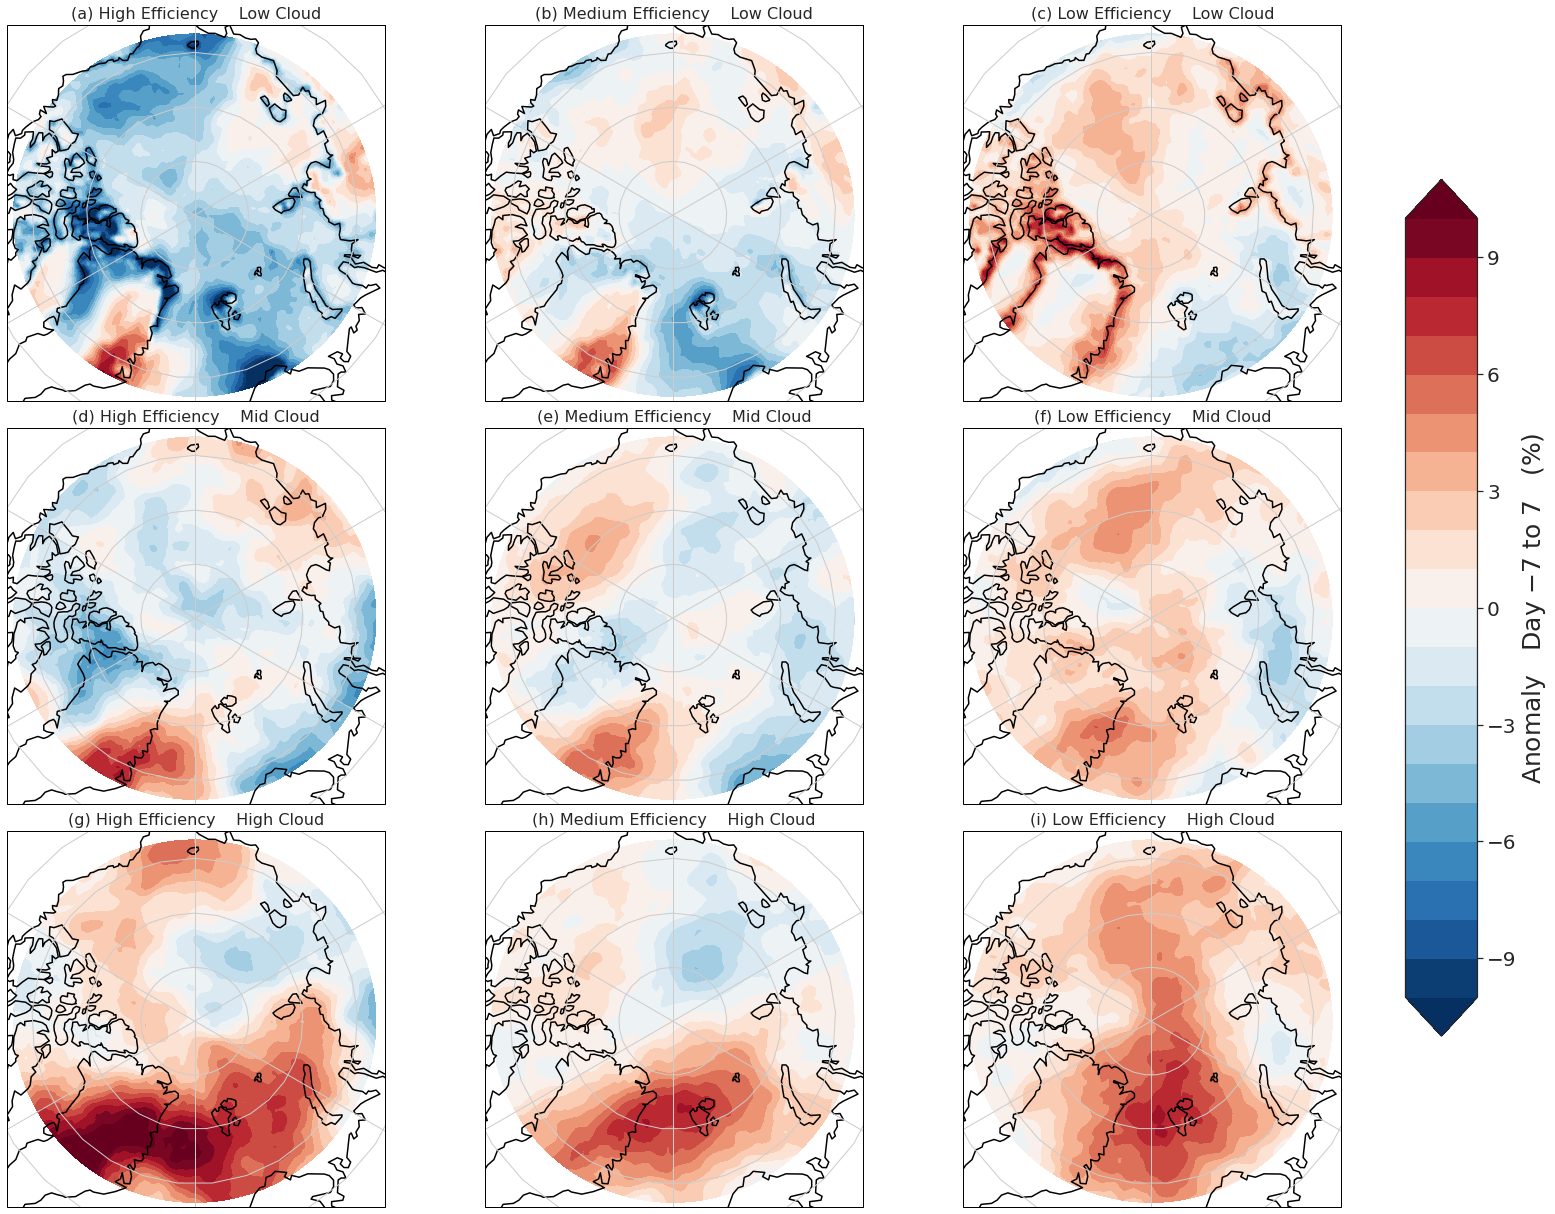

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(20, 17))
gs = plt.GridSpec(3, 3,
                       width_ratios=[1,1,1],
                       height_ratios=[1,1,1]
                       )
ax = fig.add_subplot(gs[0],projection=ccrs.NorthPolarStereo(central_longitude=0))
lev = np.arange(-10,11, 1)
cs = ax.coastlines(linewidth=1.5)
ax.gridlines()
ax.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax = ax.contourf(CLDH.lon, CLDH.lat
                  ,((CLDL_anom_comp_high_eff)*100).isel(time=slice(16,30)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax2 = fig.add_subplot(gs[1],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax2.coastlines(linewidth=1.5)
ax2.gridlines()
ax2.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax2 = ax2.contourf(CLDH.lon, CLDH.lat
                  ,((CLDL_anom_comp_med_eff)*100).isel(time=slice(16,30)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax3 = fig.add_subplot(gs[2],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax3.coastlines(linewidth=1.5)
ax3.gridlines()
ax3.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax3 = ax3.contourf(CLDH.lon, CLDH.lat
                  ,((CLDL_anom_comp_low_eff*100)).isel(time=slice(16,30)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax4 = fig.add_subplot(gs[3],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax4.coastlines(linewidth=1.5)
ax4.gridlines()
ax4.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax4 = ax4.contourf(CLDH.lon, CLDH.lat
                  ,((CLDM_anom_comp_high_eff)*100).isel(time=slice(16,30)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax5 = fig.add_subplot(gs[4],projection=ccrs.NorthPolarStereo(central_longitude=0))
#lev = np.arange(-12,14, 2)
#lev2 = np.arange(0,1.5, .5)
cs = ax5.coastlines(linewidth=1.5)
ax5.gridlines()
ax5.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax5 = ax5.contourf(CLDH.lon, CLDH.lat
                  ,((CLDM_anom_comp_med_eff)*100).isel(time=slice(16,30)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax6 = fig.add_subplot(gs[5],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax6.coastlines(linewidth=1.5)
ax6.gridlines()
ax6.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax6 = ax6.contourf(CLDH.lon, CLDH.lat
                  ,((CLDM_anom_comp_low_eff*100)).isel(time=slice(16,30)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax7 = fig.add_subplot(gs[6],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax7.coastlines(linewidth=1.5)
ax7.gridlines()
ax7.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax7 = ax7.contourf(CLDH.lon, CLDH.lat
                  ,((CLDH_anom_comp_high_eff)*100).isel(time=slice(16,30)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax8 = fig.add_subplot(gs[7],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax8.coastlines(linewidth=1.5)
ax8.gridlines()
ax8.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax8 = ax8.contourf(CLDH.lon, CLDH.lat
                  ,((CLDH_anom_comp_med_eff)*100).isel(time=slice(16,30)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax9 = fig.add_subplot(gs[8],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax9.coastlines(linewidth=1.5)
ax9.gridlines()
ax9.set_extent([-180, 180, 69, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax9 = ax9.contourf(CLDH.lon, CLDH.lat
                  ,((CLDH_anom_comp_low_eff*100)).isel(time=slice(16,30)).mean('time')
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar=fig.colorbar(cax6, cax=cbar_ax)
fig.canvas.draw()
cbar.set_label('%',fontsize=20)
ax.set_title('(a) High Efficiency    Low Cloud',fontdict={'fontsize':16})
ax2.set_title('(b) Medium Efficiency    Low Cloud',fontdict={'fontsize':16})
ax3.set_title('(c) Low Efficiency    Low Cloud',fontdict={'fontsize':16})
ax4.set_title('(d) High Efficiency    Mid Cloud',fontdict={'fontsize':16})
ax5.set_title('(e) Medium Efficiency    Mid Cloud',fontdict={'fontsize':16})
ax6.set_title('(f) Low Efficiency    Mid Cloud',fontdict={'fontsize':16})
ax7.set_title('(g) High Efficiency    High Cloud',fontdict={'fontsize':16})
ax8.set_title('(h) Medium Efficiency    High Cloud',fontdict={'fontsize':16})
ax9.set_title('(i) Low Efficiency    High Cloud',fontdict={'fontsize':16})

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider7 = make_axes_locatable(ax7)
cax7 = divider7.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider8 = make_axes_locatable(ax8)
cax8 = divider8.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider9 = make_axes_locatable(ax9)
cax9 = divider9.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)

cax.axis('off')
cax2.axis('off')
cax3.axis('off')
cax4.axis('off')
cax5.axis('off')
cax6.axis('off')
cax7.axis('off')
cax8.axis('off')
cax9.axis('off')

cbar.set_label('Anomaly   Day $-7$ to 7   (%)',fontsize=25)
cbar.ax.tick_params(labelsize=20) 

fig.tight_layout()
#plt.savefig('cld_spatial_Final.pdf', bbox_inches='tight')

## Figure 9

Time mean anomalies between day -7 and +7

In [50]:
NSF_anom_high_eff, NSF_anom_med_eff, NSF_anom_low_eff = [comp.composite_mean(DLR_anom_dtrend+ULR_anom_dtrend+SHLH_anom_dtrend,events,s=-7,e=6)
                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

SHLH_anom_high_eff, SHLH_anom_med_eff, SHLH_anom_low_eff = [comp.composite_mean(SHLH_anom_dtrend,events,s=-7,e=6)
                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

DLR_anom_high_eff, DLR_anom_med_eff, DLR_anom_low_eff = [comp.composite_mean(DLR_anom_dtrend,events,s=-7,e=6)
                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

NLR_anom_high_eff, NLR_anom_med_eff, NLR_anom_low_eff = [comp.composite_mean(DLR_anom_dtrend+ULR_anom_dtrend,events,s=-7,e=6)
                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

CLDH_pc_anom = comp.average(CLDH_anom)
CLDM_pc_anom = comp.average(CLDM_anom)
CLDL_pc_anom = comp.average(CLDL_anom)

CLDH_anom_high_eff, CLDH_anom_med_eff, CLDH_anom_low_eff = [comp.composite_mean(CLDH_pc_anom,events,s=-7,e=6)
                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

CLDM_anom_high_eff, CLDM_anom_med_eff, CLDM_anom_low_eff = [comp.composite_mean(CLDM_pc_anom,events,s=-7,e=6)
                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

CLDL_anom_high_eff, CLDL_anom_med_eff, CLDL_anom_low_eff = [comp.composite_mean(CLDL_pc_anom,events,s=-7,e=6)
                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

CREt_anom_high_eff, CREt_anom_med_eff, CREt_anom_low_eff = [comp.composite_mean(-OLR_anom_dtrend+OLR_CLR_anom_dtrend,events,s=-7,e=6)
                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

CREs_anom_high_eff, CREs_anom_med_eff, CREs_anom_low_eff = [comp.composite_mean(DLR_anom_dtrend-DLR_CLR_anom_dtrend,events,s=-7,e=6)
                                                        for events in [high_eff_time,med_eff_time,low_eff_time]]

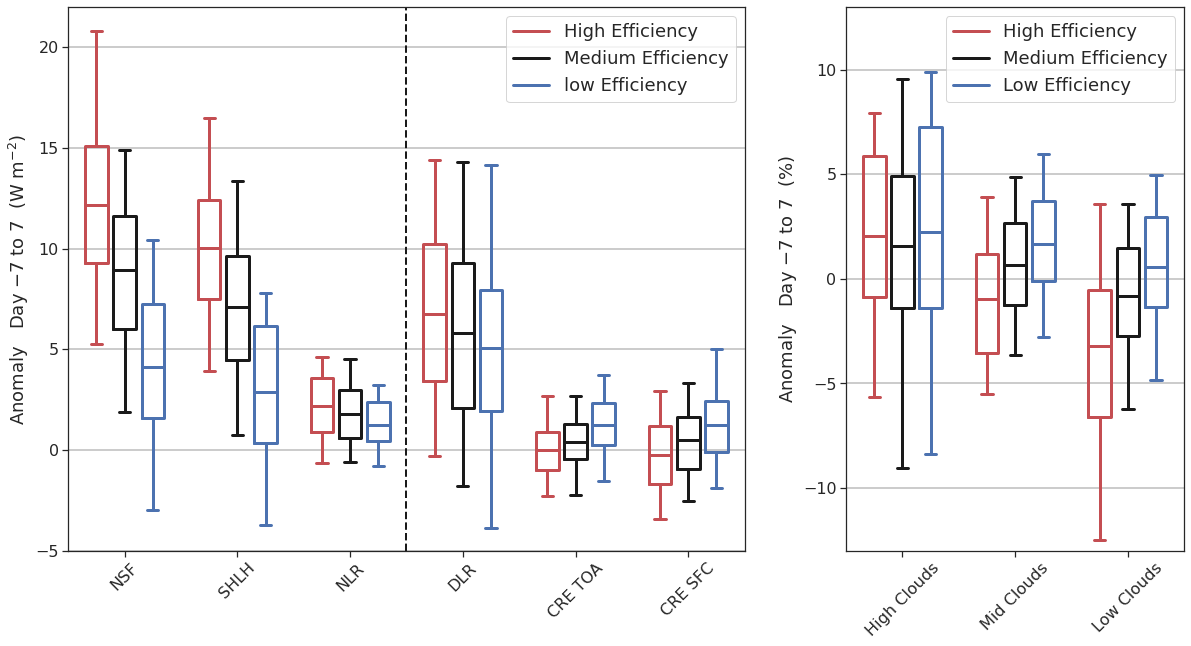

In [51]:
fig = plt.figure( figsize=(20,10) )
gs = plt.GridSpec(1, 2,
                       width_ratios=[1,.5],
                       height_ratios=[1])
ax = fig.add_subplot(gs[0])

bp1 = ax.boxplot([NSF_anom_high_eff,SHLH_anom_high_eff,NLR_anom_high_eff,DLR_anom_high_eff,CREt_anom_high_eff,CREs_anom_high_eff]
                 ,whis=[5,95],widths = .4, positions=[0,2,4,6,8,10],showfliers=False,meanline=True,showmeans=True)
plt.setp(bp1['boxes'], color='r',lw=3)
plt.setp(bp1['whiskers'], color='r',lw=3)
plt.setp(bp1['means'], color='r',lw=3,ls='-')
plt.setp(bp1['medians'], color='r',lw=3,ls='')
plt.setp(bp1['caps'], color='r',lw=3)

bp2 = ax.boxplot([NSF_anom_med_eff,SHLH_anom_med_eff,NLR_anom_med_eff,DLR_anom_med_eff,CREt_anom_med_eff,CREs_anom_med_eff]
                 ,whis=[5,95],widths = .4, positions=[.5,2.5,4.5,6.5,8.5,10.5],showfliers=False,meanline=True,showmeans=True)
plt.setp(bp2['boxes'], color='k',lw=3)
plt.setp(bp2['whiskers'], color='k',lw=3)
plt.setp(bp2['means'], color='k',lw=3,ls='-')
plt.setp(bp2['medians'], color='k',lw=3,ls='')
plt.setp(bp2['caps'], color='k',lw=3)

bp3 = ax.boxplot([NSF_anom_low_eff,SHLH_anom_low_eff,NLR_anom_low_eff,DLR_anom_low_eff,CREt_anom_low_eff,CREs_anom_low_eff]
                 ,whis=[5,95],widths = .4, positions=[1,3,5,7,9,11],showfliers=False,meanline=True,showmeans=True)
plt.setp(bp3['boxes'], color='b',lw=3)
plt.setp(bp3['whiskers'], color='b',lw=3)
plt.setp(bp3['means'], color='b',lw=3,ls='-')
plt.setp(bp3['medians'], color='b',lw=3,ls='')
plt.setp(bp3['caps'], color='b',lw=3)

ax.set_xticks([.5,2.5,4.5,6.5,8.5,10.5])
ax.set_xticklabels(['NSF','SHLH','NLR','DLR',
                    'CRE TOA','CRE SFC'],
                    rotation=45, fontsize=18)
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['High Efficiency', 'Medium Efficiency', 'low Efficiency'], loc='upper right',fontsize=18)
ax.grid(axis='y',lw=2)
ax.set_ylabel('Anomaly   Day $-7$ to $7$  (W m$^{-2}$)',fontsize=18)

ax2 = fig.add_subplot(gs[1])

bp4 = ax2.boxplot([CLDH_anom_high_eff*100,CLDM_anom_high_eff*100,CLDL_anom_high_eff*100]
                  ,whis=[5,95],widths = .4, positions=[0,2,4],showfliers=False,meanline=True,showmeans=True)
plt.setp(bp4['boxes'], color='r',lw=3)
plt.setp(bp4['whiskers'], color='r',lw=3)
plt.setp(bp4['means'], color='r',lw=3,ls='-')
plt.setp(bp4['medians'], color='r',lw=3,ls='')
plt.setp(bp4['caps'], color='r',lw=3)

bp5 = ax2.boxplot([CLDH_anom_med_eff*100,CLDM_anom_med_eff*100,CLDL_anom_med_eff*100]
                  ,whis=[5,95],widths = .4, positions=[.5,2.5,4.5],showfliers=False,meanline=True,showmeans=True)
plt.setp(bp5['boxes'], color='k',lw=3)
plt.setp(bp5['whiskers'], color='k',lw=3)
plt.setp(bp5['means'], color='k',lw=3,ls='-')
plt.setp(bp5['medians'], color='k',lw=3,ls='')
plt.setp(bp5['caps'], color='k',lw=3)

bp6 = ax2.boxplot([CLDH_anom_low_eff*100,CLDM_anom_low_eff*100,CLDL_anom_low_eff*100]
                  ,whis=[5,95],widths = .4, positions=[1,3,5],showfliers=False,meanline=True,showmeans=True)
plt.setp(bp6['boxes'], color='b',lw=3)
plt.setp(bp6['whiskers'], color='b',lw=3)
plt.setp(bp6['means'], color='b',lw=3,ls='-')
plt.setp(bp6['medians'], color='b',lw=3,ls='')
plt.setp(bp6['caps'], color='b',lw=3)

ax2.set_xticks([.5,2.5,4.5])
ax2.set_xticklabels(['High Clouds','Mid Clouds','Low Clouds'],
                    rotation=45, fontsize=16)
ax2.legend([bp4["boxes"][0], bp5["boxes"][0], bp6["boxes"][0]], ['High Efficiency', 'Medium Efficiency', 'Low Efficiency'], loc='upper right',fontsize=18)
ax2.grid(axis='y',lw=2)
ax2.set_ylabel('Anomaly   Day $-7$ to $7$  (%)',fontsize=18)

ax.set_ybound(-5,22)
ax2.set_ybound(-13,13)

ax.axvline(5.5,color='k',ls='--',lw=2)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

#plt.savefig('boxplot_composite_Final.pdf', bbox_inches='tight')

## Figure 10

In [52]:
from IPython.display import IFrame
IFrame("SchematicEfficiency.pdf", width=600, height=650)

## Figure 11

In [53]:
years = MSE.groupby(MSE.time.dt.year).mean().year
high_count = high_eff_time.groupby(high_eff_time.time.dt.year).count()
low_count = low_eff_time.groupby(low_eff_time.time.dt.year).count()
medium_count = med_eff_time.groupby(med_eff_time.time.dt.year).count()

high_count = xr.broadcast(years,high_count)[1].fillna(0)
low_count = xr.broadcast(years,low_count)[1].fillna(0)
medium_count = xr.broadcast(years,medium_count)[1].fillna(0)

high_count2=high_eff_time.where(xr.ufuncs.logical_or(DLR_anom.time.dt.month<=3,DLR_anom.time.dt.month>=11)).resample(time='AS-NOV').count().fillna(0)
low_count2=low_eff_time.where(xr.ufuncs.logical_or(DLR_anom.time.dt.month<=3,DLR_anom.time.dt.month>=11)).resample(time='AS-NOV').count().fillna(0)
medium_count2=med_eff_time.where(xr.ufuncs.logical_or(DLR_anom.time.dt.month<=3,DLR_anom.time.dt.month>=11)).resample(time='AS-NOV').count().fillna(0)


In [54]:
events_per_year = xr.concat([E_trop_event.time.resample(time='10Y',closed='left').count()/np.array([10,10,10,10]),
    high_eff_time.resample(time='10Y',closed='left').count()/np.array([10,10,10,10]),
med_eff_time.resample(time='10Y',closed='left').count()/np.array([10,10,10,10]),
low_eff_time.resample(time='10Y',closed='left').count()/np.array([10,10,10,10])],'Efficiency',coords='minimal',compat='override')

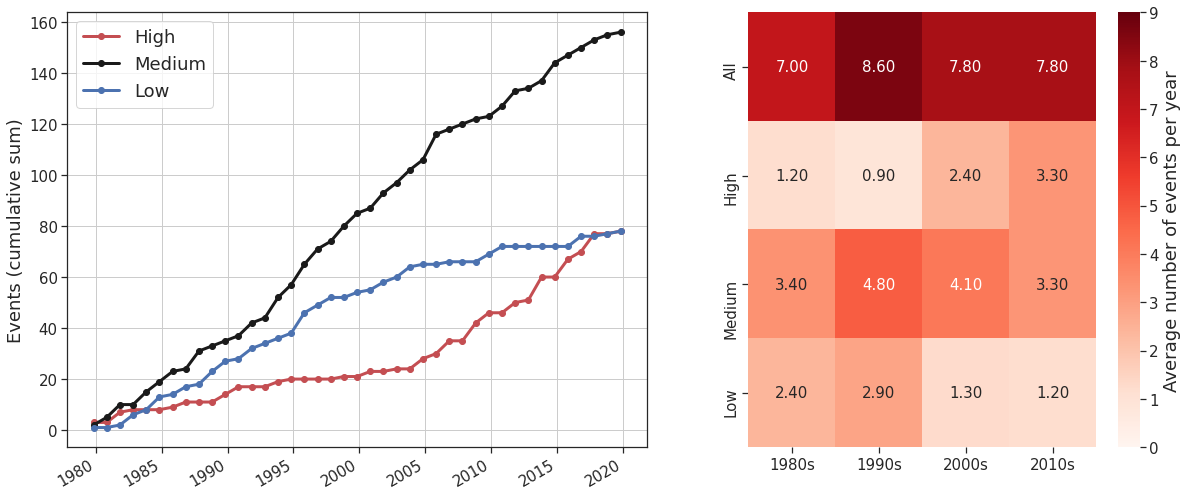

In [55]:
fig = plt.figure(figsize=(20, 8))
gs = plt.GridSpec(1, 2,
                       width_ratios=[1,.75],
                       height_ratios=[1]
                       )
ax = fig.add_subplot(gs[0])
high_count2.cumsum().plot(color='r',lw=3,marker='o',ax=ax,label='High')
medium_count2.cumsum().plot(color='k',lw=3,marker='o',ax=ax,label='Medium')
low_count2.cumsum().plot(color='b',lw=3,marker='o',ax=ax,label='Low')

ax2 = fig.add_subplot(gs[1])
im=sns.heatmap(events_per_year,annot=True,annot_kws={"size":15},fmt=".2f",ax=ax2,cmap='Reds',vmin=0,vmax=9)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Average number of events per year',fontsize=18)

ax2.set_yticklabels(['All','High','Medium','Low'])
ax2.set_xticklabels(['1980s','1990s','2000s','2010s'])
ax.set_ylabel('Events (cumulative sum)', fontsize=18)
#ax.set_xlabel('Year', fontsize=15)
ax.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax.legend(fontsize=18)
ax.set_title('')
ax.set_xlabel('')
ax.grid()
#plt.savefig('event_trends_Final.pdf', bbox_inches='tight')